# **Importing library&function**






In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, mean_squared_error, auc
from IPython.core.display import display, HTML
import numpy as np
import time
import os
from google.colab import drive
import itertools

!pip install split_folders
import splitfolders

!pip install scikit-learn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/
import splitfolders
import os
loc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Dataset/grayscale/"
# csvloc = "/content/drive/MyDrive/ColabNotebooks/FinalProject/Result/"

gray_cataract  gray_diabetic_retinopathy  gray_glaucoma  gray_normal


In [4]:
import os
splitfolders.ratio(loc,output = "outputgrayscale",ratio = (0.70,0.15,0.15))
for dirpath,dirname,filename in os.walk("./outputgrayscale"):
  print(f"There are {len(dirname)} directories and {len(filename)} images in '{dirpath}'.")

Copying files: 4238 files [00:50, 84.57 files/s] 

There are 3 directories and 0 images in './outputgrayscale'.
There are 4 directories and 0 images in './outputgrayscale/test'.
There are 0 directories and 162 images in './outputgrayscale/test/gray_normal'.
There are 0 directories and 166 images in './outputgrayscale/test/gray_diabetic_retinopathy'.
There are 0 directories and 154 images in './outputgrayscale/test/gray_glaucoma'.
There are 0 directories and 158 images in './outputgrayscale/test/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/train'.
There are 0 directories and 751 images in './outputgrayscale/train/gray_normal'.
There are 0 directories and 769 images in './outputgrayscale/train/gray_diabetic_retinopathy'.
There are 0 directories and 711 images in './outputgrayscale/train/gray_glaucoma'.
There are 0 directories and 733 images in './outputgrayscale/train/gray_cataract'.
There are 4 directories and 0 images in './outputgrayscale/val'.
There are 0 directories and 161 images in './outputgrayscale/

In [5]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",patience = 6,
                                             min_delta = 0.0001)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss",factor = 0.2,
                                                patience = 4,min_lr = 1e-7)

In [6]:
data_aug = tf.keras.Sequential([
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomHeight(0.2),
    # preprocessing.RandomRotation(0.2),
    # preprocessing.RandomFlip("horizontal")
],name = "data_augmentation_layer")

In [7]:
def predict_labels(model, X_test):
    return model.predict(X_test)

def display_classification_report(y_test, y_pred):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

def calculate_specificity(y_test, y_pred):
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # specificity = tn / (tn + fp)
    # print(f"Specificity: {specificity}")
    cm = confusion_matrix(y_test, y_pred)
    specificity = []
    for i in range(cm.shape[0]):
      spec = cm[i, i] / (np.sum(cm[i, :]) - cm[i, i] + np.sum(cm[:, :]) - np.sum(cm[i, :]))
      specificity.append(spec)
    print(f"Specificity: {specificity}")

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize
    n_classes = cm.shape[0]  # find the number of classes

    specificity = []  # To store specificity values for each class

    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),
        yticks=np.arange(n_classes),
        xticklabels=labels,
        yticklabels=labels
    )

    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    plt.xticks(rotation=70, fontsize=text_size)
    plt.yticks(fontsize=text_size)

    threshold = (cm.max() + cm.min()) / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        specificity_val = (cm.sum() - cm[i].sum() - cm[:, j].sum() + cm[i, j]) / (
            cm.sum() - cm[:, j].sum()
        )
        specificity.append(specificity_val)

        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%,\n {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%, Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]} ( {specificity_val*100:.1f}%)",
                #  f"{cm[i, j]} (Specificity: {specificity_val*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    if savefig:
        fig.savefig("confusion_matrix.png")

    return specificity

def calculate_mse(y_test, y_probs, n_classes):
  y_true_onehot = tf.keras.utils.to_categorical(y_test, n_classes)
  mse = mean_squared_error(y_true_onehot, y_probs)
  print(f"Mean Squared Error: : {mse}")
  return y_true_onehot

def calculate_roc_auc_score(y_test, y_probs):
  auc_roc = roc_auc_score(y_test, y_probs, multi_class='ovr', average=None)
  average_auc_roc = np.mean(auc_roc)
  print(f"The average AUC-ROC is {average_auc_roc}")

# **Batch size: 16**

In [8]:
epoch = 20
batchsize = 16

In [9]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 2964 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 634 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [10]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


52606240/52606240 [==============================] - 0s 0us/step


In [11]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 32)                49184     
                                                             

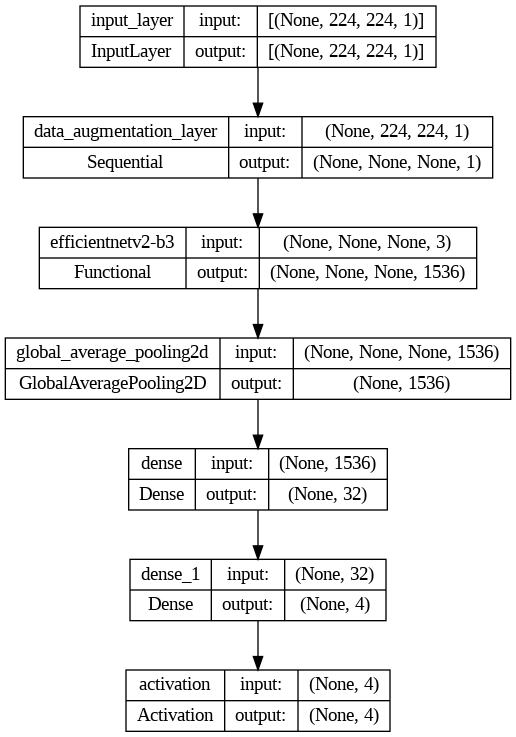

In [12]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [13]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [14]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
186/186 [==============================] - 73s 285ms/step - loss: 0.6672 - accuracy: 0.7264 - val_loss: 0.5228 - val_accuracy: 0.7965 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 43s 228ms/step - loss: 0.5145 - accuracy: 0.8063 - val_loss: 0.4611 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 38s 201ms/step - loss: 0.4458 - accuracy: 0.8296 - val_loss: 0.4244 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 4/20
186/186 [==============================] - 36s 196ms/step - loss: 0.4414 - accuracy: 0.8357 - val_loss: 0.4170 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 5/20
186/186 [==============================] - 34s 183ms/step - loss: 0.4159 - accuracy: 0.8367 - val_loss: 0.4577 - val_accuracy: 0.8218 - lr: 0.0010
Epoch 6/20
186/186 [==============================] - 29s 157ms/step - loss: 0.4064 - accuracy: 0.8458 - val_loss: 0.3977 - val_accuracy: 0.8502 - lr: 0.0010
Epoch 7/20
186/186 [==============================] 

EfficientNetV2B3 Evaluation

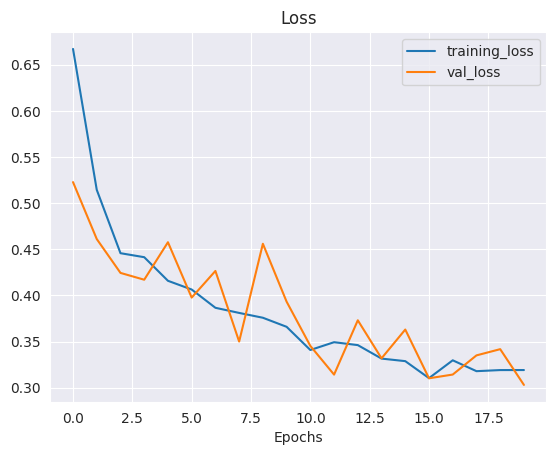

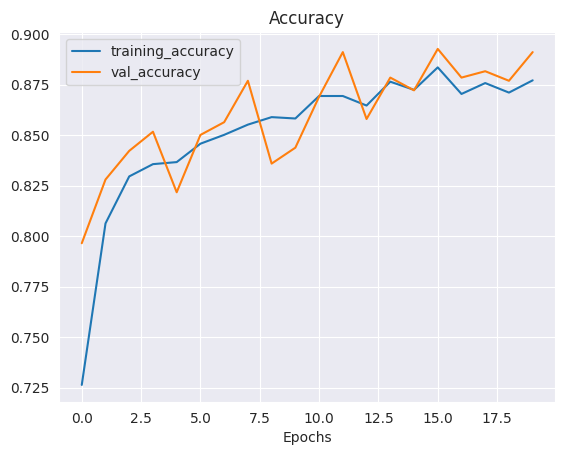

In [15]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 2s 42ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       158
           1       0.96      0.98      0.97       166
           2       0.89      0.74      0.81       154
           3       0.80      0.89      0.84       162

    accuracy                           0.88       640
   macro avg       0.88      0.88      0.88       640
weighted avg       0.89      0.88      0.88       640

Specificity: [0.29292929292929293, 0.3389121338912134, 0.21673003802281368, 0.2903225806451613]
Mean Squared Error: : 0.11412278562784195
The average AUC-ROC is 0.9782473310550417


[0.9726890756302521,
 0.6652542372881356,
 0.701171875,
 0.6739130434782609,
 0.6533613445378151,
 0.9915254237288136,
 0.67578125,
 0.6456521739130435,
 0.7058823529411765,
 0.6758474576271186,
 0.921875,
 0.7195652173913043,
 0.6680672268907563,
 0.6673728813559322,
 0.701171875,
 0.9608695652173913]

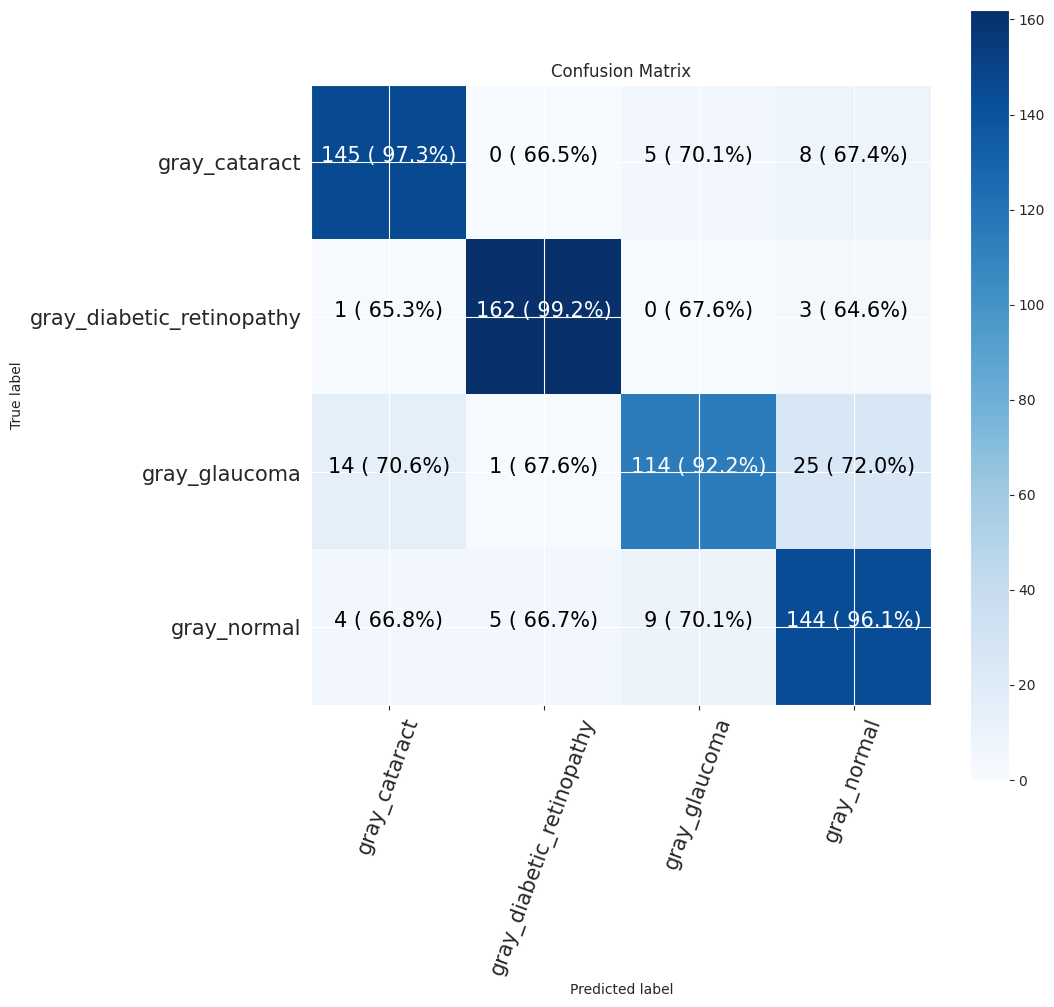

In [16]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


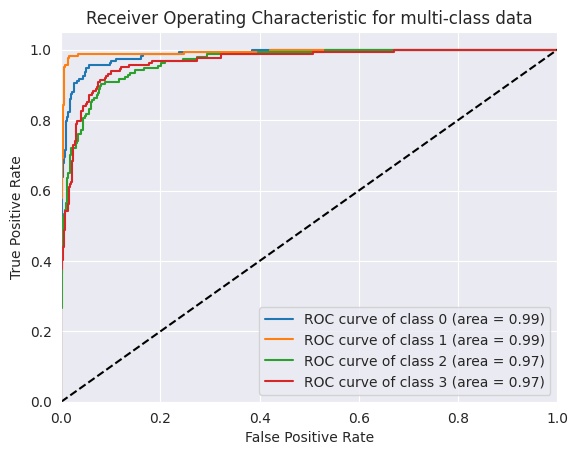

In [17]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [18]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

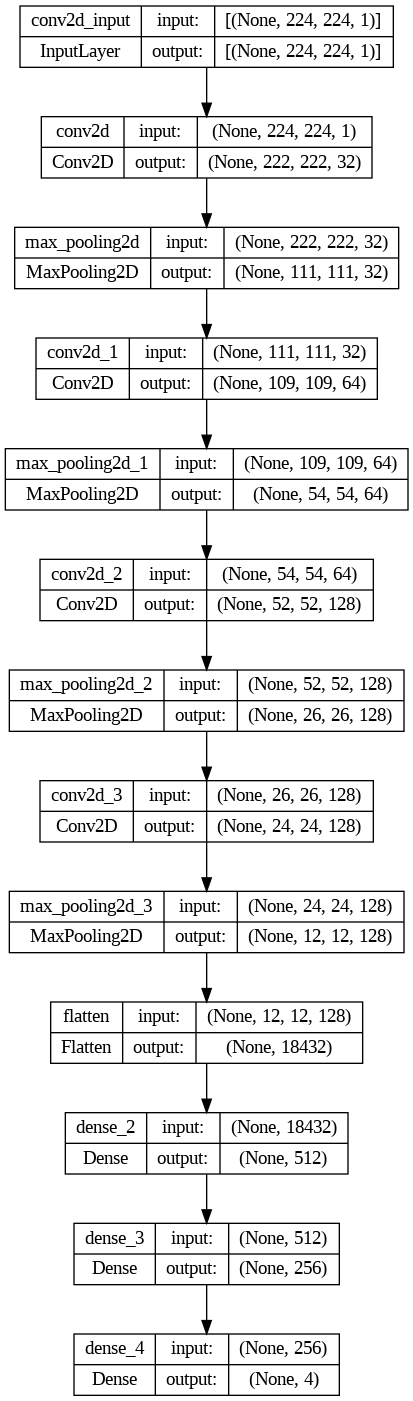

In [19]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [20]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [21]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
186/186 [==============================] - 8s 24ms/step - loss: 1.7842 - accuracy: 0.6039 - val_loss: 0.8022 - val_accuracy: 0.6483 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 4s 21ms/step - loss: 0.5787 - accuracy: 0.7446 - val_loss: 0.6950 - val_accuracy: 0.7271 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 4s 21ms/step - loss: 0.5765 - accuracy: 0.7470 - val_loss: 0.4785 - val_accuracy: 0.8297 - lr: 0.0010
Epoch 4/20
186/186 [==============================] - 4s 21ms/step - loss: 0.5203 - accuracy: 0.7733 - val_loss: 0.5247 - val_accuracy: 0.7697 - lr: 0.0010
Epoch 5/20
186/186 [==============================] - 4s 21ms/step - loss: 0.4192 - accuracy: 0.8293 - val_loss: 0.4885 - val_accuracy: 0.7855 - lr: 0.0010
Epoch 6/20
186/186 [==============================] - 4s 21ms/step - loss: 0.4844 - accuracy: 0.8128 - val_loss: 0.9608 - val_accuracy: 0.6830 - lr: 0.0010
Epoch 7/20
186/186 [==============================] - 4s 21ms/st

CNN Evaluation

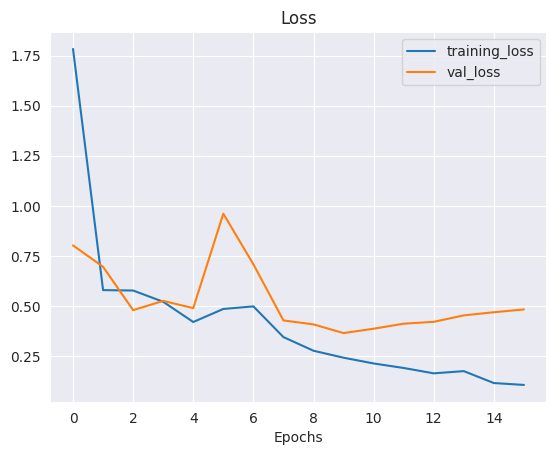

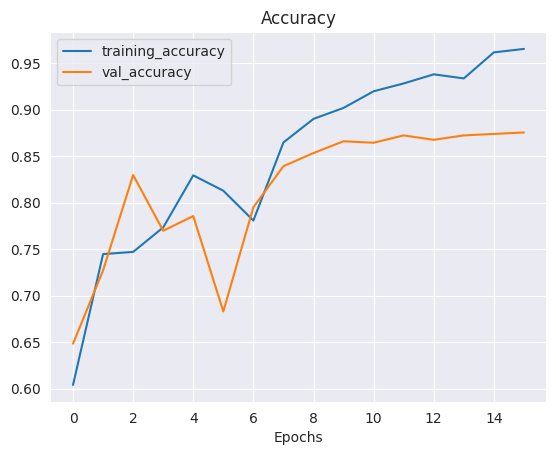

In [22]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       158
           1       0.99      1.00      0.99       166
           2       0.81      0.71      0.76       154
           3       0.79      0.90      0.84       162

    accuracy                           0.86       640
   macro avg       0.86      0.86      0.86       640
weighted avg       0.86      0.86      0.86       640

Specificity: [0.25984251968503935, 0.350210970464135, 0.20754716981132076, 0.29292929292929293]
Mean Squared Error: : 0.1150895208120346
The average AUC-ROC is 0.9627529682737741


[0.946611909650924,
 0.6652542372881356,
 0.7142857142857143,
 0.6805251641137856,
 0.6591375770020534,
 1.0,
 0.6706349206349206,
 0.6367614879649891,
 0.7186858316221766,
 0.6758474576271186,
 0.9126984126984127,
 0.7199124726477024,
 0.675564681724846,
 0.6588983050847458,
 0.7023809523809523,
 0.962800875273523]

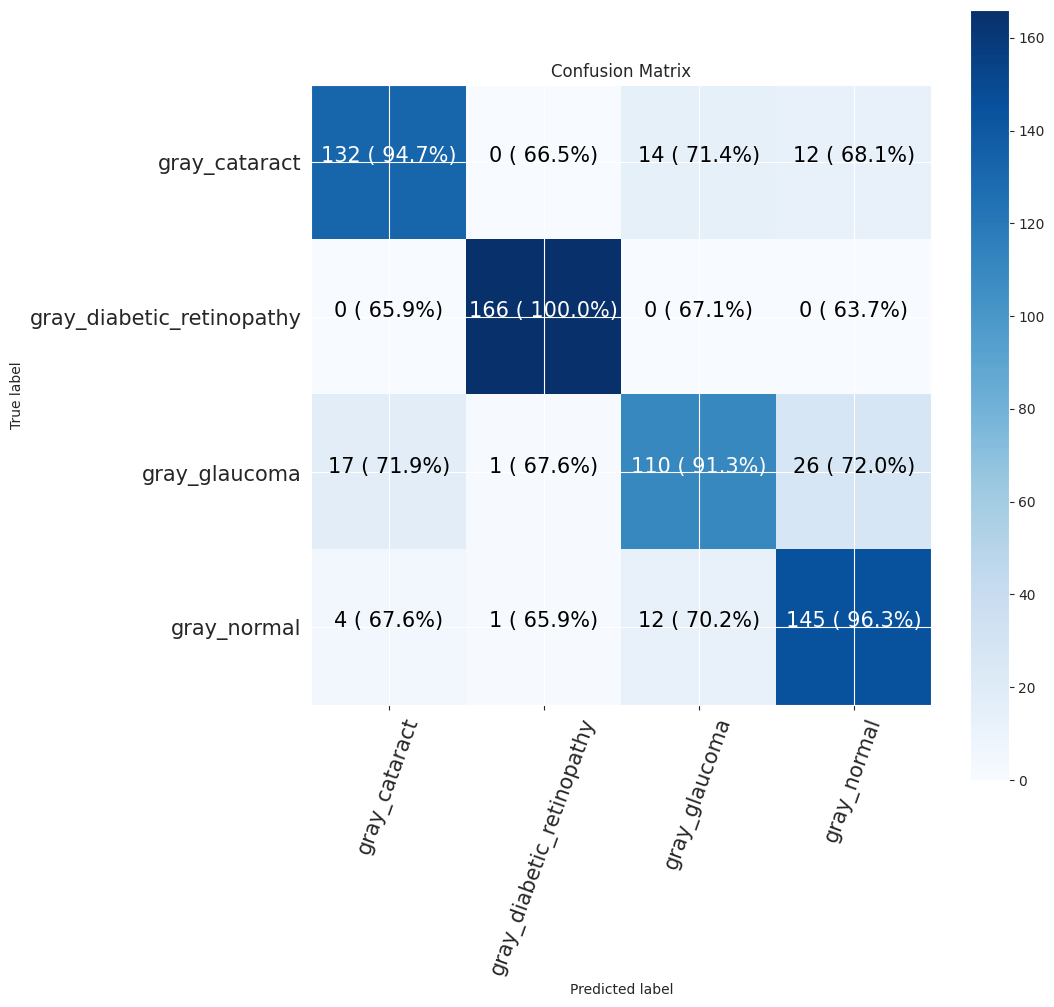

In [23]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


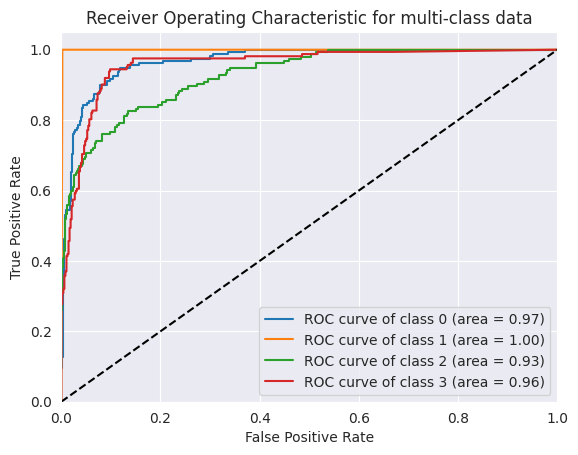

In [24]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [25]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


94765736/94765736 [==============================] - 0s 0us/step
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_4 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_6 (Dense)             (None, 4)                 4100 

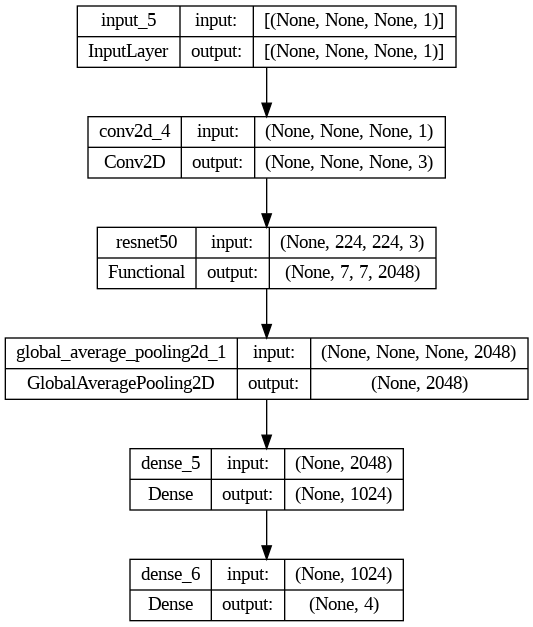

In [26]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [27]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [28]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
186/186 [==============================] - 34s 153ms/step - loss: 0.6428 - accuracy: 0.7726 - val_loss: 0.4443 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 27s 143ms/step - loss: 0.3846 - accuracy: 0.8489 - val_loss: 0.3750 - val_accuracy: 0.8502 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 27s 142ms/step - loss: 0.3040 - accuracy: 0.8802 - val_loss: 0.4219 - val_accuracy: 0.8391 - lr: 0.0010
Epoch 4/20
186/186 [==============================] - 26s 142ms/step - loss: 0.2590 - accuracy: 0.8947 - val_loss: 0.2701 - val_accuracy: 0.8943 - lr: 0.0010
Epoch 5/20
186/186 [==============================] - 26s 142ms/step - loss: 0.2416 - accuracy: 0.9049 - val_loss: 0.2654 - val_accuracy: 0.9022 - lr: 0.0010
Epoch 6/20
186/186 [==============================] - 26s 142ms/step - loss: 0.2215 - accuracy: 0.9184 - val_loss: 0.5406 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 7/20
186/186 [==============================] 

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 2s 49ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       158
           1       0.99      0.99      0.99       166
           2       0.86      0.86      0.86       154
           3       0.88      0.89      0.88       162

    accuracy                           0.91       640
   macro avg       0.91      0.91      0.91       640
weighted avg       0.91      0.91      0.91       640

Specificity: [0.2903225806451613, 0.3445378151260504, 0.25984251968503935, 0.2903225806451613]
Mean Squared Error: : 0.10727452486753464
The average AUC-ROC is 0.985947562740693


[0.9710144927536232,
 0.6666666666666666,
 0.6919917864476386,
 0.680672268907563,
 0.6583850931677019,
 0.9957805907172996,
 0.6591375770020534,
 0.6533613445378151,
 0.6997929606625258,
 0.6751054852320675,
 0.9548254620123203,
 0.7037815126050421,
 0.6708074534161491,
 0.6624472573839663,
 0.6940451745379876,
 0.9621848739495799]

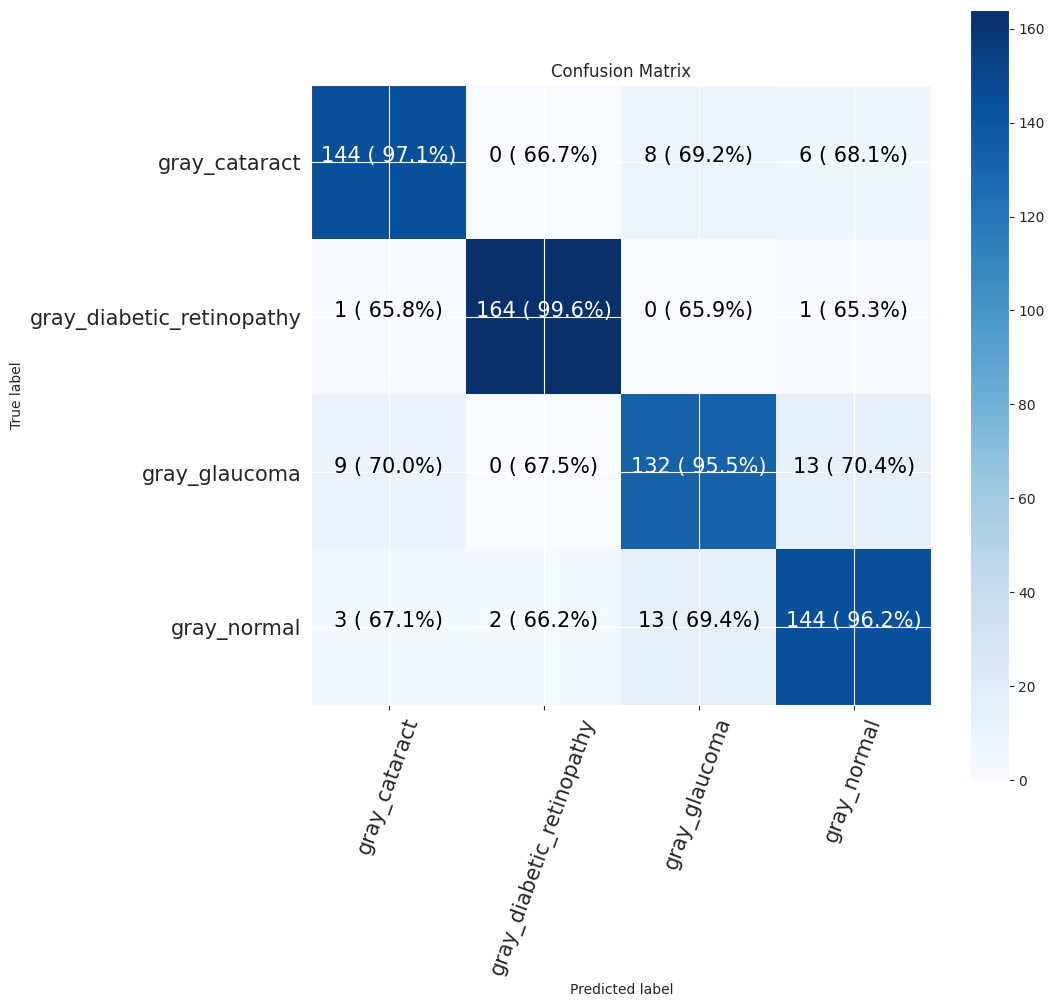

In [29]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


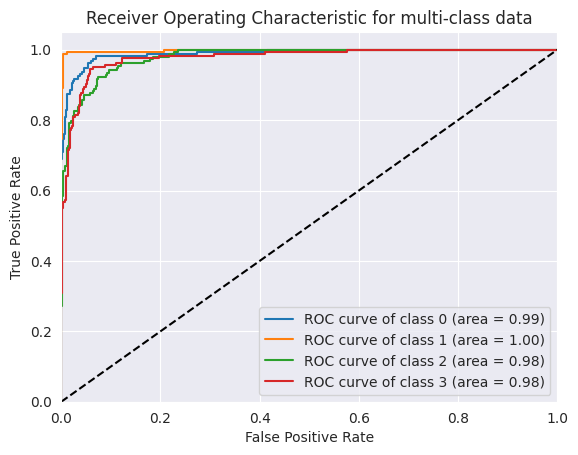

In [30]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [31]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


171446536/171446536 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_5 (Conv2D)           (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_7 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_8 (Dense)             (None, 4)                 410

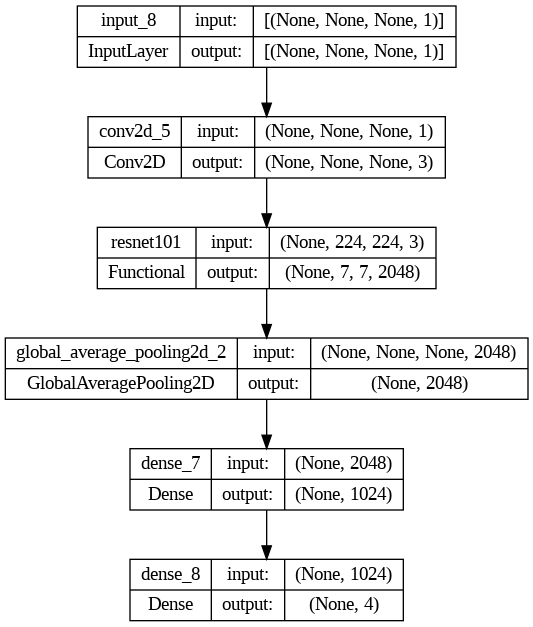

In [32]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [33]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [34]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
186/186 [==============================] - 52s 243ms/step - loss: 0.6711 - accuracy: 0.7618 - val_loss: 0.4545 - val_accuracy: 0.8265 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 43s 234ms/step - loss: 0.4293 - accuracy: 0.8316 - val_loss: 0.3836 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 43s 232ms/step - loss: 0.3362 - accuracy: 0.8684 - val_loss: 0.3482 - val_accuracy: 0.8596 - lr: 0.0010
Epoch 4/20
186/186 [==============================] - 44s 234ms/step - loss: 0.2988 - accuracy: 0.8846 - val_loss: 0.3205 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 5/20
186/186 [==============================] - 43s 233ms/step - loss: 0.2604 - accuracy: 0.8944 - val_loss: 0.3079 - val_accuracy: 0.8849 - lr: 0.0010
Epoch 6/20
186/186 [==============================] - 43s 232ms/step - loss: 0.2854 - accuracy: 0.8870 - val_loss: 0.3043 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 7/20
186/186 [==============================] 

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


40/40 [==============================] - 3s 85ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       158
           1       0.98      0.98      0.98       166
           2       0.77      0.86      0.81       154
           3       0.86      0.80      0.83       162

    accuracy                           0.88       640
   macro avg       0.88      0.88      0.88       640
weighted avg       0.88      0.88      0.88       640

Specificity: [0.27236580516898606, 0.3417190775681342, 0.25984251968503935, 0.2549019607843137]
Mean Squared Error: : 0.11052558571100235
The average AUC-ROC is 0.9770252938864343


[0.9570552147239264,
 0.6659619450317125,
 0.6886993603411514,
 0.6952965235173824,
 0.6625766871165644,
 0.9936575052854123,
 0.650319829424307,
 0.6605316973415133,
 0.7034764826175869,
 0.6765327695560254,
 0.9530916844349681,
 0.7096114519427403,
 0.6768916155419223,
 0.6638477801268499,
 0.7078891257995735,
 0.934560327198364]

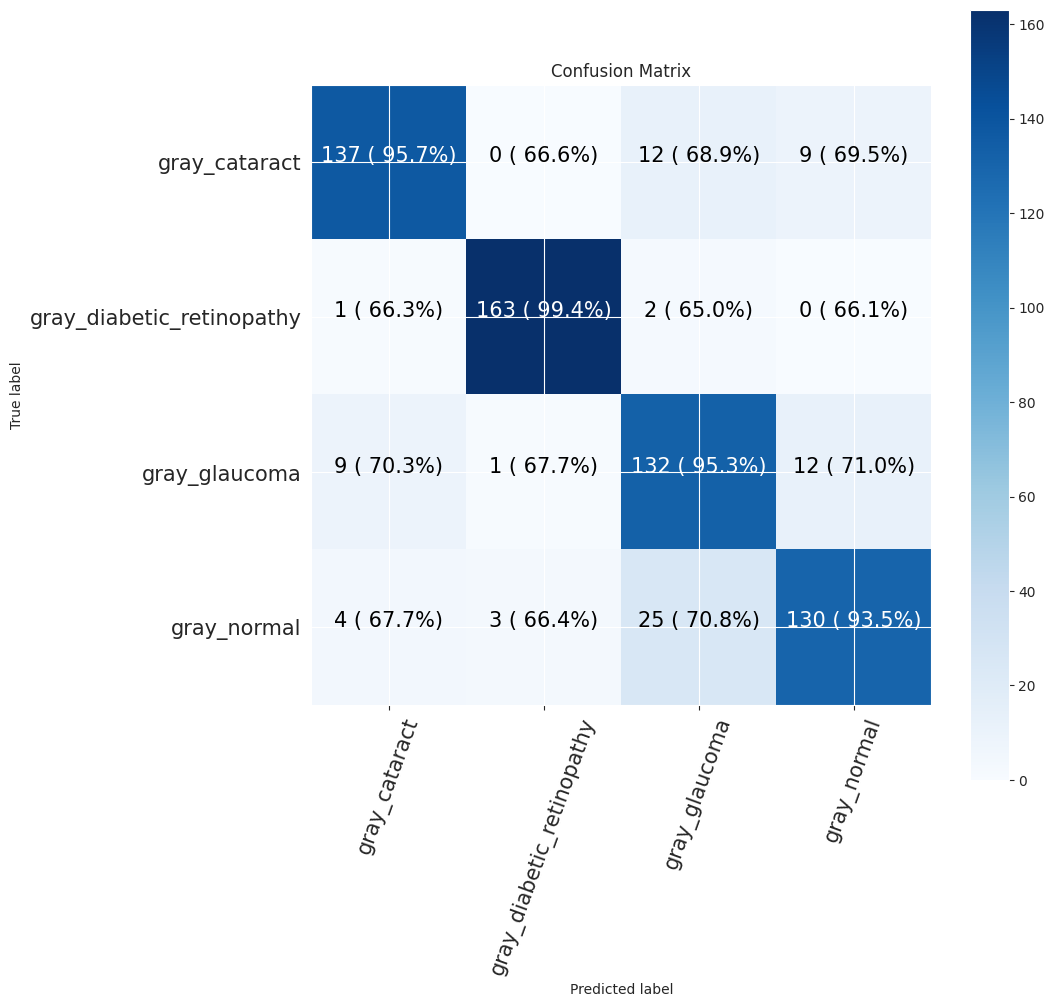

In [35]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


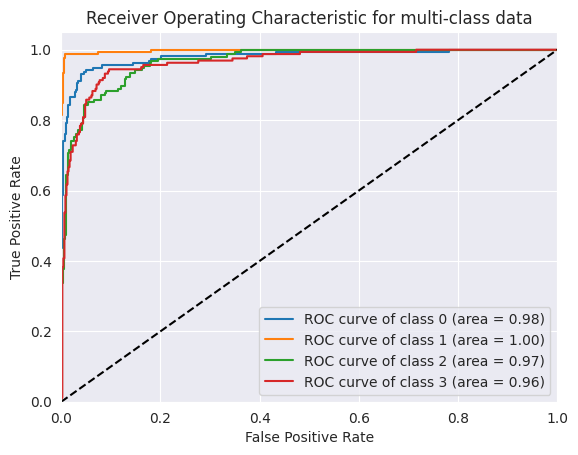

In [36]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 32**

In [37]:
epoch = 20
batchsize = 32

In [38]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 2964 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 634 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [39]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [40]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_3  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 32)                49184     
                                                           

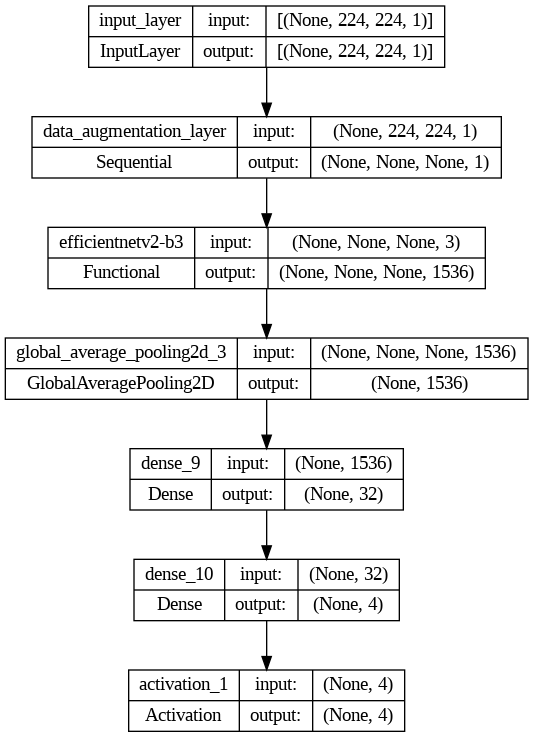

In [41]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [42]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [43]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
93/93 [==============================] - 60s 521ms/step - loss: 0.7647 - accuracy: 0.6930 - val_loss: 0.5665 - val_accuracy: 0.7681 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 42s 450ms/step - loss: 0.5293 - accuracy: 0.7868 - val_loss: 0.4453 - val_accuracy: 0.8328 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 37s 401ms/step - loss: 0.5068 - accuracy: 0.8043 - val_loss: 0.4525 - val_accuracy: 0.8423 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 33s 359ms/step - loss: 0.4393 - accuracy: 0.8239 - val_loss: 0.4823 - val_accuracy: 0.8170 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 34s 367ms/step - loss: 0.4165 - accuracy: 0.8387 - val_loss: 0.3664 - val_accuracy: 0.8738 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 30s 327ms/step - loss: 0.4140 - accuracy: 0.8465 - val_loss: 0.3899 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 30s 322ms/st

EfficientNetV2B3 Evaluation

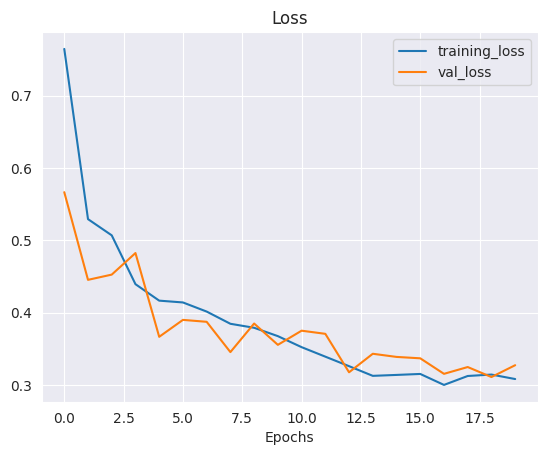

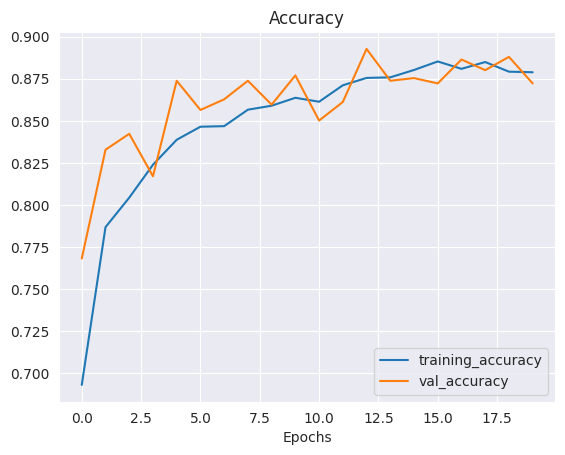

In [44]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 2s 78ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90       158
           1       0.98      0.96      0.97       166
           2       0.91      0.71      0.80       154
           3       0.78      0.93      0.85       162

    accuracy                           0.88       640
   macro avg       0.89      0.88      0.88       640
weighted avg       0.89      0.88      0.88       640

Specificity: [0.2903225806451613, 0.3333333333333333, 0.20754716981132076, 0.30879345603271985]
Mean Squared Error: : 0.11638342589139938
The average AUC-ROC is 0.9739827466153096


[0.9707112970711297,
 0.6687631027253669,
 0.7052023121387283,
 0.6659192825112108,
 0.6548117154811716,
 0.9874213836477987,
 0.6801541425818882,
 0.6390134529147982,
 0.7092050209205021,
 0.6771488469601677,
 0.9152215799614644,
 0.7197309417040358,
 0.6652719665271967,
 0.6666666666666666,
 0.6994219653179191,
 0.9753363228699552]

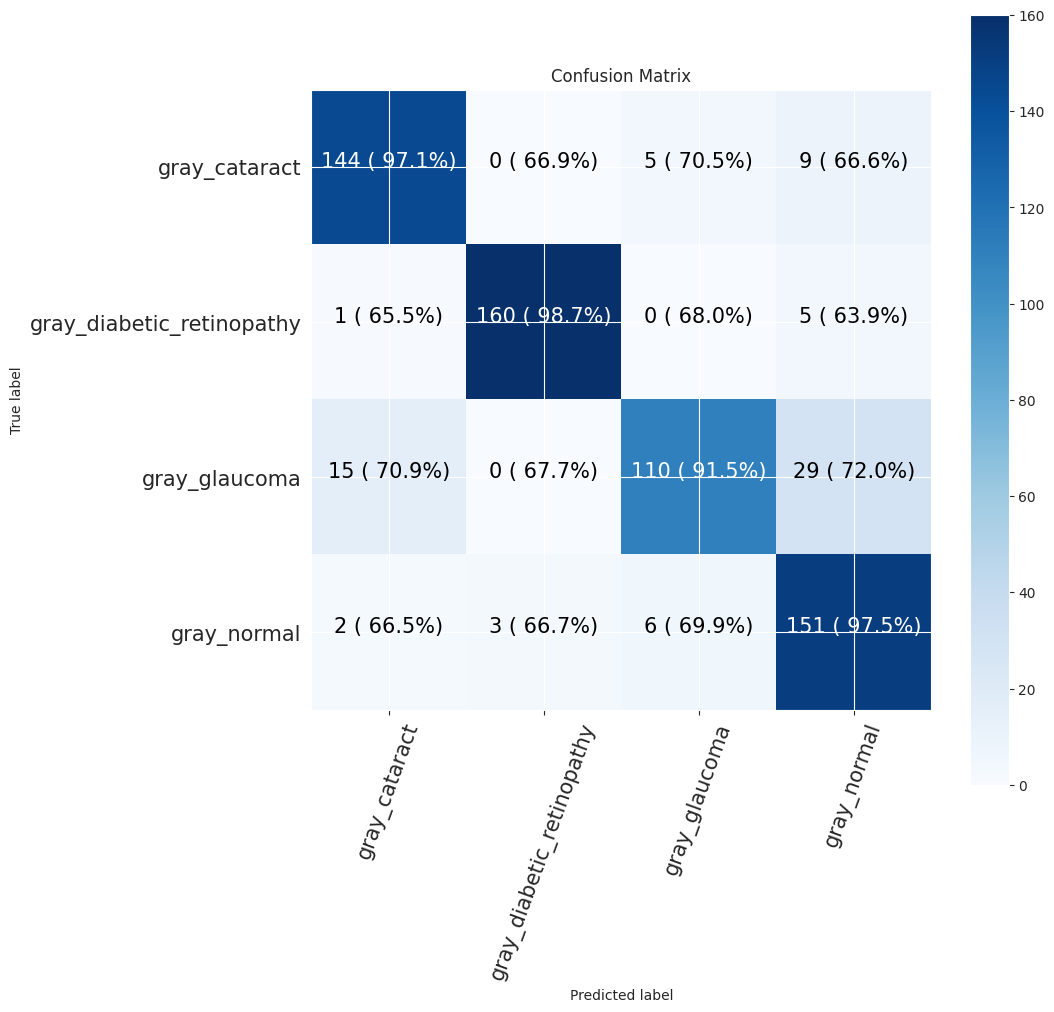

In [45]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


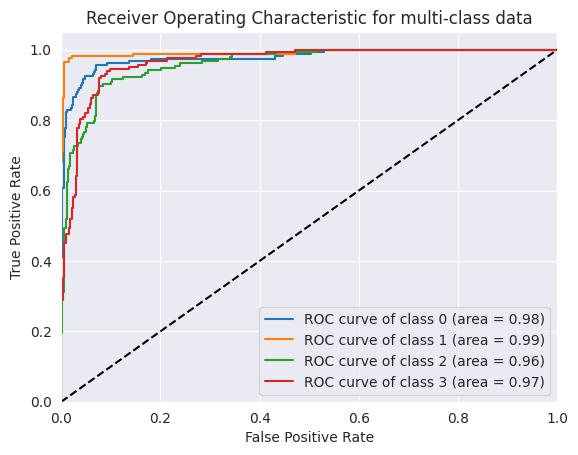

In [46]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [47]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 26, 26, 128)      

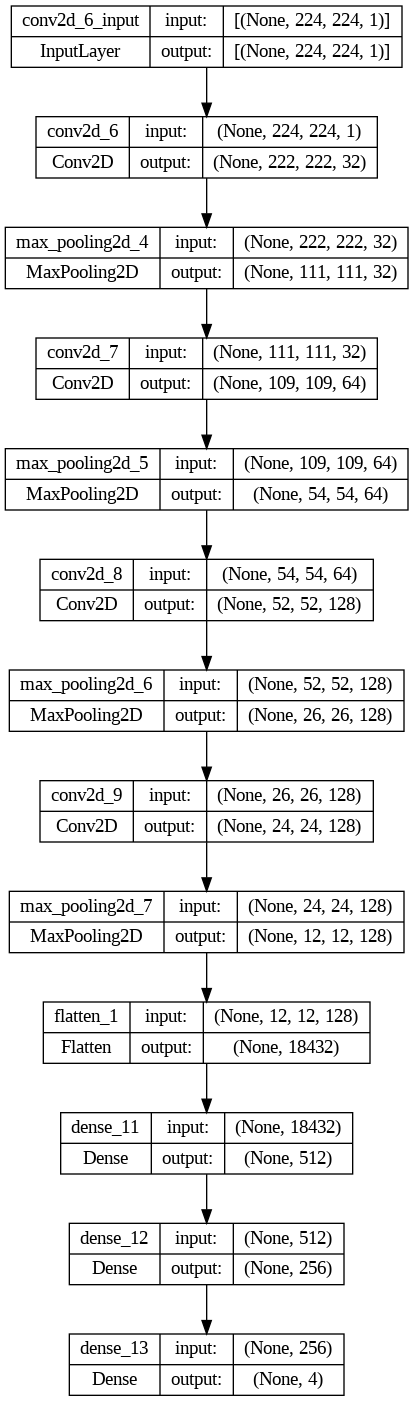

In [48]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [49]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [50]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
93/93 [==============================] - 7s 46ms/step - loss: 3.7764 - accuracy: 0.5196 - val_loss: 0.7392 - val_accuracy: 0.7192 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 4s 38ms/step - loss: 0.6420 - accuracy: 0.7183 - val_loss: 0.5548 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 4s 37ms/step - loss: 0.5498 - accuracy: 0.7588 - val_loss: 0.5260 - val_accuracy: 0.7886 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 4s 38ms/step - loss: 0.4783 - accuracy: 0.7918 - val_loss: 0.5246 - val_accuracy: 0.7776 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 4s 37ms/step - loss: 0.4480 - accuracy: 0.8074 - val_loss: 0.5439 - val_accuracy: 0.7776 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 4s 38ms/step - loss: 0.4443 - accuracy: 0.8023 - val_loss: 0.5171 - val_accuracy: 0.7524 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 4s 38ms/step - loss: 0.4

CNN Evaluation

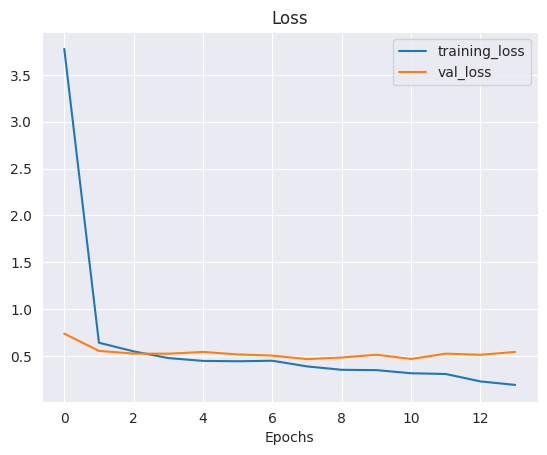

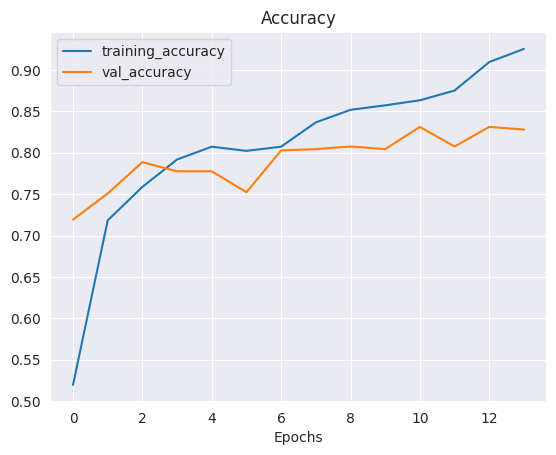

In [51]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 0s 14ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.73      0.77       158
           1       0.99      0.99      0.99       166
           2       0.72      0.71      0.71       154
           3       0.78      0.85      0.81       162

    accuracy                           0.82       640
   macro avg       0.82      0.82      0.82       640
weighted avg       0.83      0.82      0.82       640

Specificity: [0.22137404580152673, 0.3473684210526316, 0.20527306967984935, 0.2749003984063745]
Mean Squared Error: : 0.12075701355934143
The average AUC-ROC is 0.9475573516189241


[0.9151515151515152,
 0.6666666666666666,
 0.7336065573770492,
 0.6889848812095032,
 0.6646464646464646,
 0.9978902953586498,
 0.6618852459016393,
 0.6414686825053996,
 0.7292929292929293,
 0.6751054852320675,
 0.9077868852459017,
 0.7213822894168467,
 0.6909090909090909,
 0.6603375527426161,
 0.6967213114754098,
 0.9481641468682506]

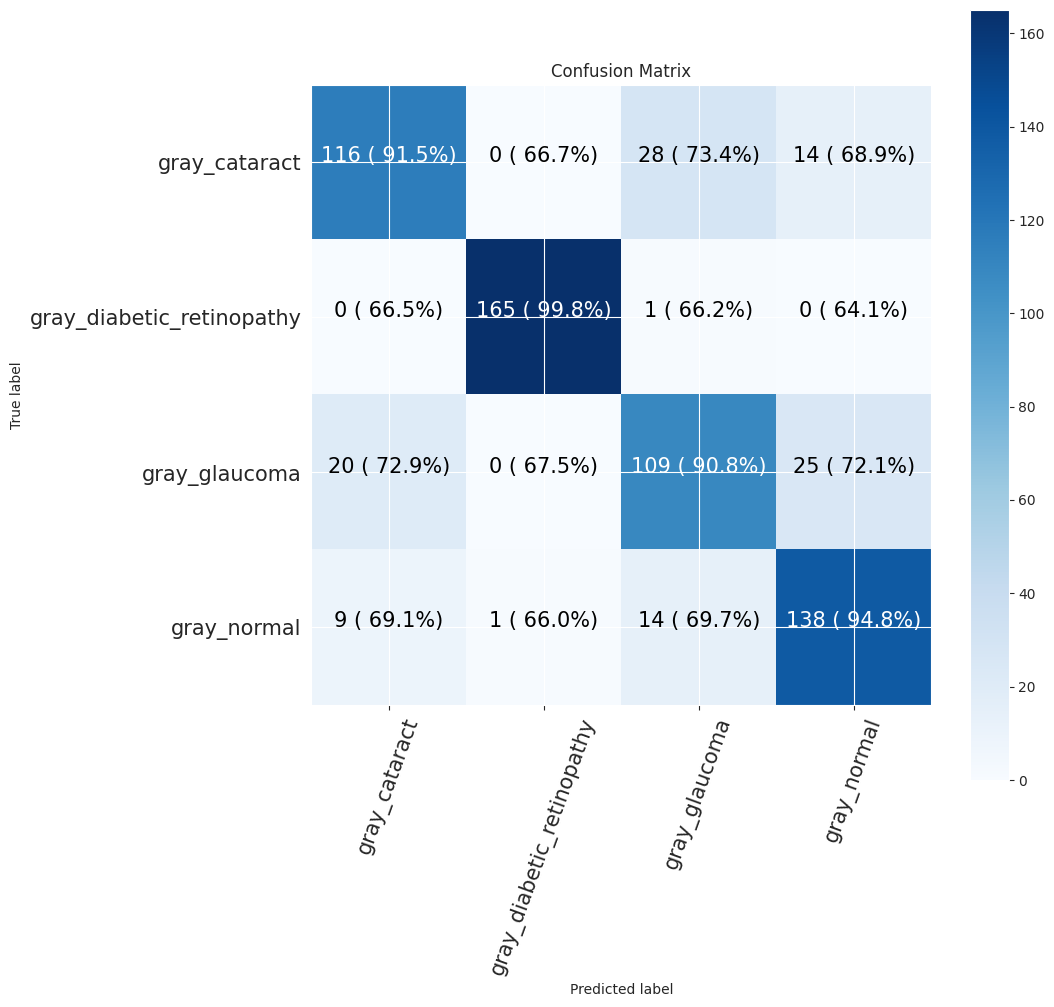

In [52]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


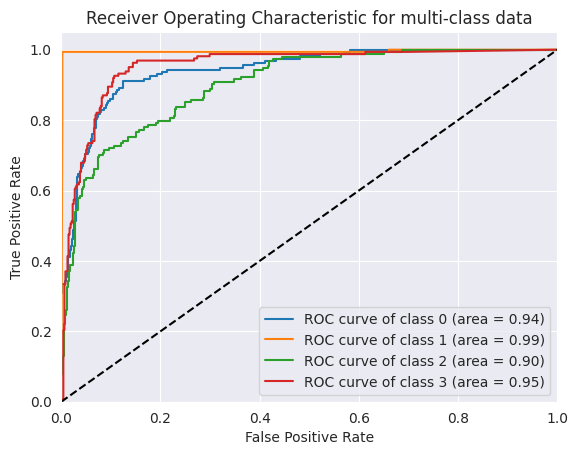

In [53]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [54]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_10 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_4  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_14 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_15 (Dense)            (None, 4)                 4100      
                                                           

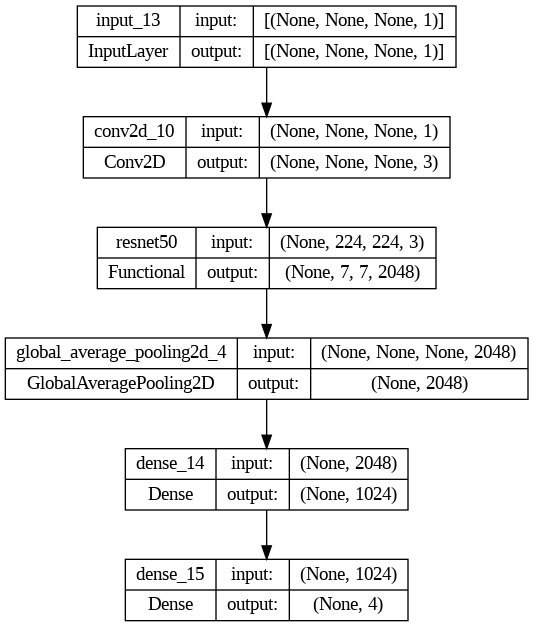

In [55]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [56]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [57]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
93/93 [==============================] - 34s 305ms/step - loss: 0.6289 - accuracy: 0.7729 - val_loss: 0.4997 - val_accuracy: 0.8091 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 25s 272ms/step - loss: 0.3671 - accuracy: 0.8596 - val_loss: 0.3160 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 25s 270ms/step - loss: 0.2991 - accuracy: 0.8920 - val_loss: 0.3560 - val_accuracy: 0.8596 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 25s 270ms/step - loss: 0.2727 - accuracy: 0.8947 - val_loss: 0.2803 - val_accuracy: 0.8959 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 25s 270ms/step - loss: 0.2356 - accuracy: 0.9099 - val_loss: 0.2983 - val_accuracy: 0.8943 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 25s 269ms/step - loss: 0.2440 - accuracy: 0.9042 - val_loss: 0.2929 - val_accuracy: 0.9022 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 25s 271ms/st

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 2s 94ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.88      0.91       158
           1       0.98      0.99      0.98       166
           2       0.82      0.87      0.84       154
           3       0.87      0.86      0.87       162

    accuracy                           0.90       640
   macro avg       0.90      0.90      0.90       640
weighted avg       0.90      0.90      0.90       640

Specificity: [0.2774451097804391, 0.3445378151260504, 0.2648221343873518, 0.28]
Mean Squared Error: : 0.1073596328496933
The average AUC-ROC is 0.9850641075526249


[0.9613821138211383,
 0.6659619450317125,
 0.6932773109243697,
 0.6847599164926931,
 0.6646341463414634,
 0.9957716701902748,
 0.6533613445378151,
 0.6534446764091858,
 0.6971544715447154,
 0.6765327695560254,
 0.957983193277311,
 0.7077244258872651,
 0.676829268292683,
 0.6617336152219874,
 0.6953781512605042,
 0.954070981210856]

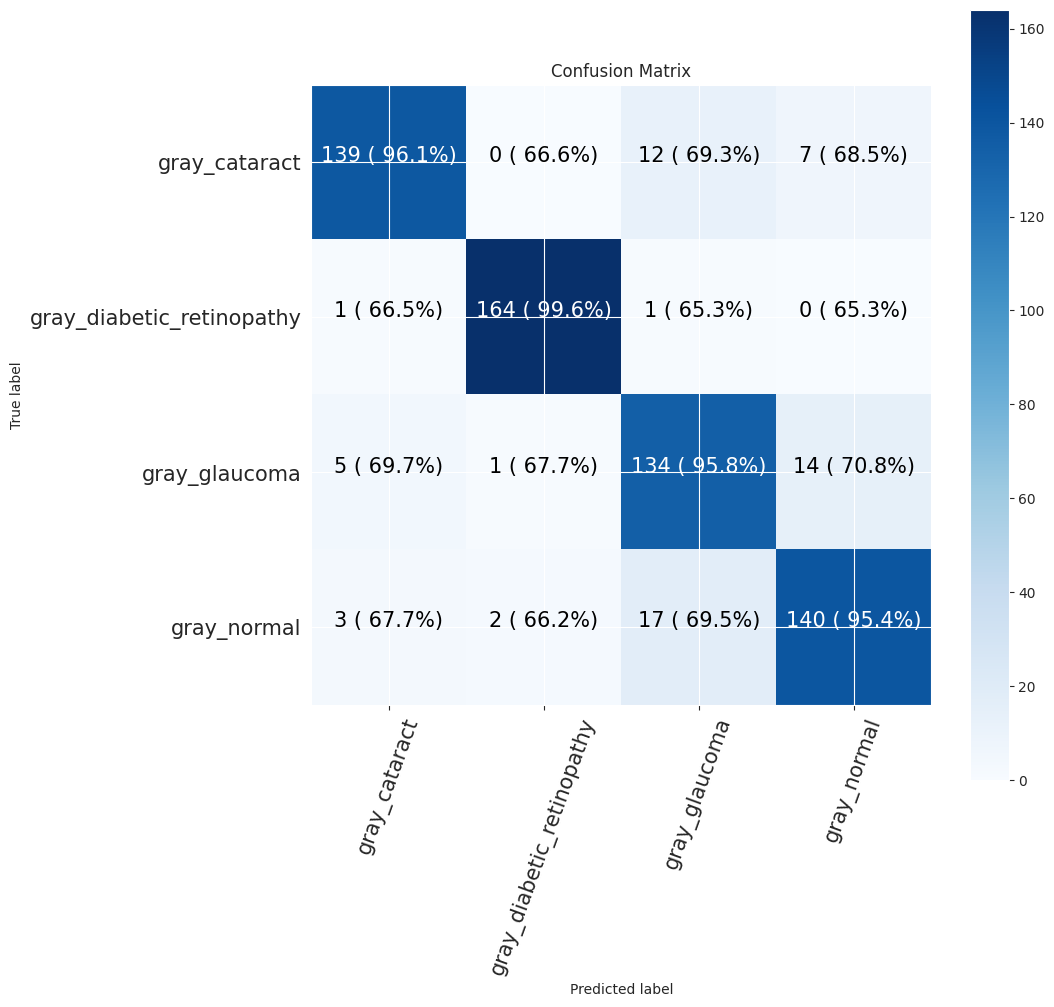

In [58]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


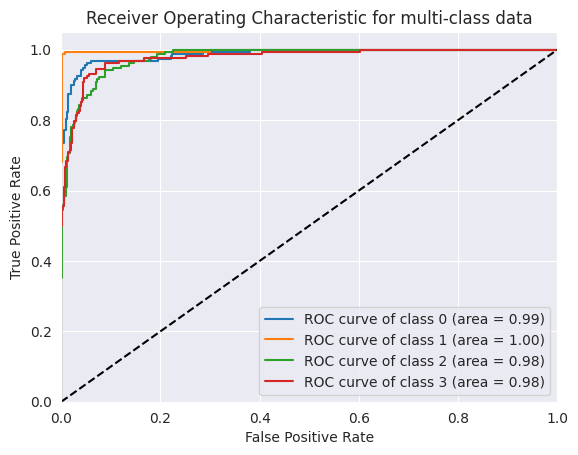

In [59]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [60]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_11 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_5  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_17 (Dense)            (None, 4)                 4100      
                                                           

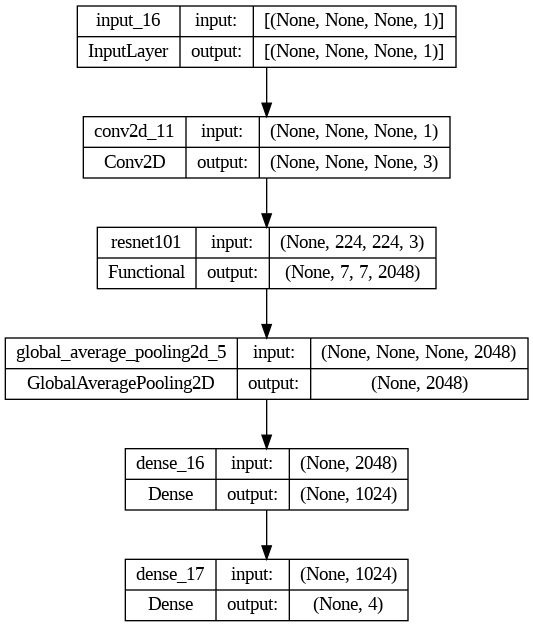

In [61]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [62]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [63]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
93/93 [==============================] - 52s 471ms/step - loss: 0.8148 - accuracy: 0.7210 - val_loss: 0.4604 - val_accuracy: 0.8139 - lr: 0.0010
Epoch 2/20
93/93 [==============================] - 42s 446ms/step - loss: 0.3958 - accuracy: 0.8451 - val_loss: 0.4722 - val_accuracy: 0.7918 - lr: 0.0010
Epoch 3/20
93/93 [==============================] - 42s 448ms/step - loss: 0.3565 - accuracy: 0.8509 - val_loss: 0.3565 - val_accuracy: 0.8565 - lr: 0.0010
Epoch 4/20
93/93 [==============================] - 41s 445ms/step - loss: 0.3232 - accuracy: 0.8731 - val_loss: 0.3196 - val_accuracy: 0.8722 - lr: 0.0010
Epoch 5/20
93/93 [==============================] - 42s 449ms/step - loss: 0.2871 - accuracy: 0.8877 - val_loss: 0.3729 - val_accuracy: 0.8549 - lr: 0.0010
Epoch 6/20
93/93 [==============================] - 41s 445ms/step - loss: 0.3020 - accuracy: 0.8806 - val_loss: 0.3968 - val_accuracy: 0.8454 - lr: 0.0010
Epoch 7/20
93/93 [==============================] - 42s 446ms/st

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 3s 162ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       158
           1       0.98      0.98      0.98       166
           2       0.82      0.82      0.82       154
           3       0.84      0.81      0.83       162

    accuracy                           0.88       640
   macro avg       0.88      0.88      0.88       640
weighted avg       0.88      0.88      0.88       640

Specificity: [0.2903225806451613, 0.3389121338912134, 0.245136186770428, 0.25984251968503935]
Mean Squared Error: : 0.11190766096115112
The average AUC-ROC is 0.9783206154664436


[0.9705263157894737,
 0.6673684210526316,
 0.6940451745379876,
 0.6832298136645962,
 0.6526315789473685,
 0.991578947368421,
 0.6591375770020534,
 0.6625258799171843,
 0.6989473684210527,
 0.6757894736842105,
 0.9425051334702259,
 0.7163561076604554,
 0.6778947368421052,
 0.6652631578947369,
 0.704312114989733,
 0.937888198757764]

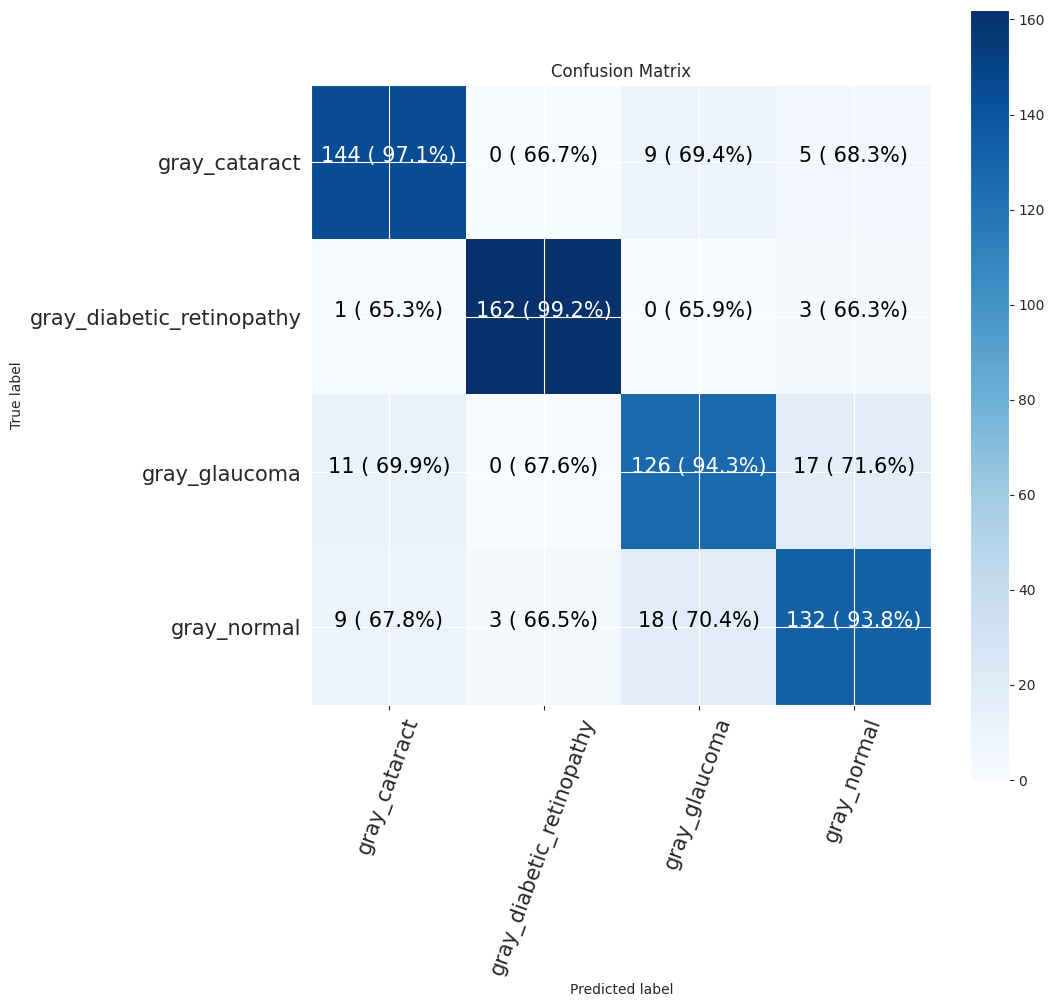

In [64]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


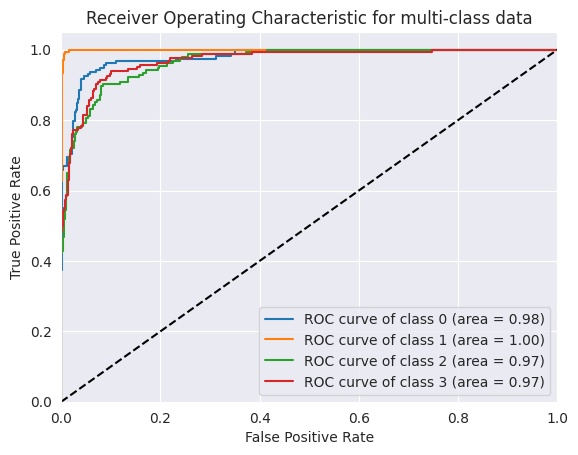

In [65]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **Batch size: 64**

In [66]:
epoch = 20
batchsize = 64

In [67]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

train_dir = "outputgrayscale/train"
test_dir =  "outputgrayscale/test"
val_dir = "outputgrayscale/val"

train_data = image_dataset_from_directory(train_dir, label_mode="categorical",
                                          image_size=(224, 224), batch_size=batchsize,
                                          shuffle=True, seed=42, color_mode='grayscale')

test_data = image_dataset_from_directory(test_dir, label_mode="categorical",
                                         image_size=(224, 224), batch_size=batchsize,
                                         shuffle=False, seed=42, color_mode='grayscale')

val_data = image_dataset_from_directory(val_dir, label_mode="categorical",
                                        image_size=(224, 224), batch_size=batchsize,
                                        shuffle=False, seed=42, color_mode='grayscale')


Found 2964 files belonging to 4 classes.
Found 640 files belonging to 4 classes.
Found 634 files belonging to 4 classes.


# **EfficientNetV2B3 Model**

In [68]:
efficient_model = tf.keras.applications.EfficientNetV2B3(include_top = False)
efficient_model.trainable = False


In [69]:
inputs = layers.Input(shape=(224, 224, 1), name="input_layer")
x = data_aug(inputs)
# x = inputs
x = efficient_model(x)

# Apply Global Average Pooling
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(32, activation="relu", kernel_initializer=tf.keras.initializers.he_normal())(x)
x = layers.Dense(4)(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)

efficient_model = tf.keras.Model(inputs, outputs)
efficient_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 1)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 1)     0         
 equential)                                                      
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d_6  (None, 1536)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_18 (Dense)            (None, 32)                49184     
                                                           

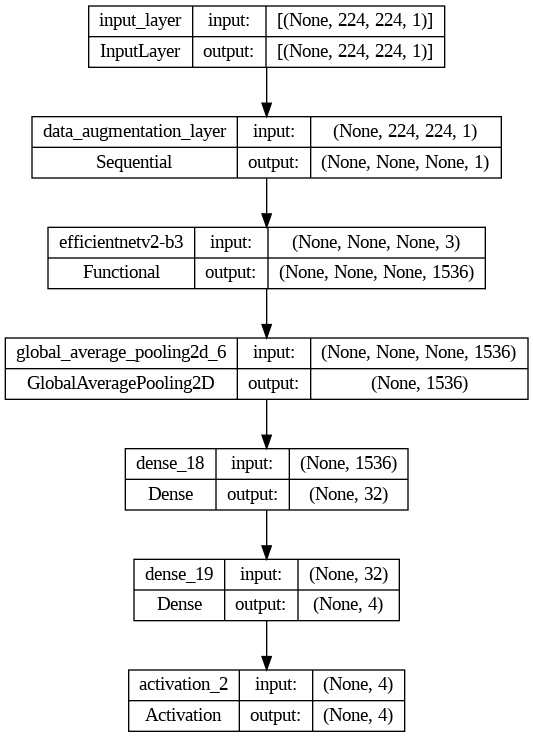

In [70]:
tf.keras.utils.plot_model(efficient_model, show_shapes=True)

In [71]:
efficient_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [72]:
efficient_history = efficient_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
47/47 [==============================] - 57s 997ms/step - loss: 0.7969 - accuracy: 0.6711 - val_loss: 0.5589 - val_accuracy: 0.7855 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 39s 831ms/step - loss: 0.5598 - accuracy: 0.7874 - val_loss: 0.5870 - val_accuracy: 0.7634 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 37s 792ms/step - loss: 0.5079 - accuracy: 0.7969 - val_loss: 0.4613 - val_accuracy: 0.8281 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 36s 771ms/step - loss: 0.4803 - accuracy: 0.8144 - val_loss: 0.4718 - val_accuracy: 0.8218 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 37s 786ms/step - loss: 0.4627 - accuracy: 0.8195 - val_loss: 0.4823 - val_accuracy: 0.8218 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 34s 729ms/step - loss: 0.4297 - accuracy: 0.8384 - val_loss: 0.4328 - val_accuracy: 0.8375 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 34s 721ms/st

EfficientNetV2B3 Evaluation

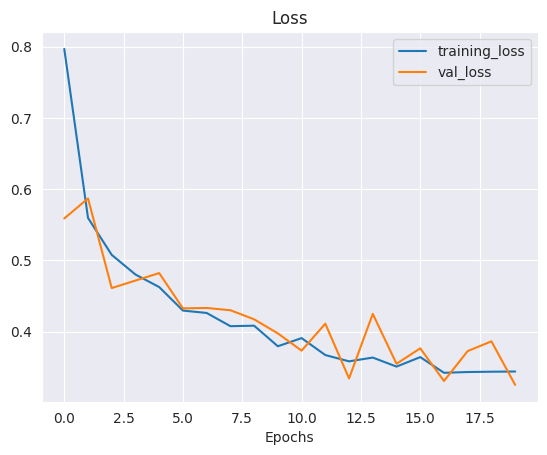

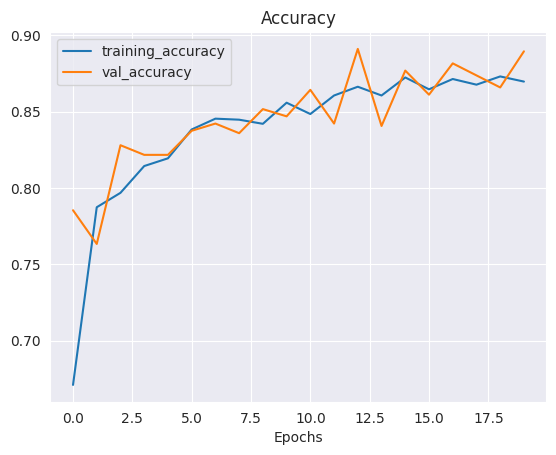

In [73]:
plot_loss_curves(efficient_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 1s 151ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       158
           1       0.90      0.98      0.94       166
           2       0.85      0.75      0.80       154
           3       0.86      0.78      0.82       162

    accuracy                           0.87       640
   macro avg       0.87      0.87      0.86       640
weighted avg       0.87      0.87      0.86       640

Specificity: [0.30612244897959184, 0.3417190775681342, 0.21904761904761905, 0.2475633528265107]
Mean Squared Error: : 0.11812610179185867
The average AUC-ROC is 0.9725744347431692


[0.9827586206896551,
 0.6550218340611353,
 0.695049504950495,
 0.6876267748478702,
 0.6443965517241379,
 0.9934497816593887,
 0.6712871287128713,
 0.6673427991886409,
 0.7112068965517241,
 0.6746724890829694,
 0.9227722772277228,
 0.716024340770791,
 0.6616379310344828,
 0.6768558951965066,
 0.7108910891089109,
 0.9290060851926978]

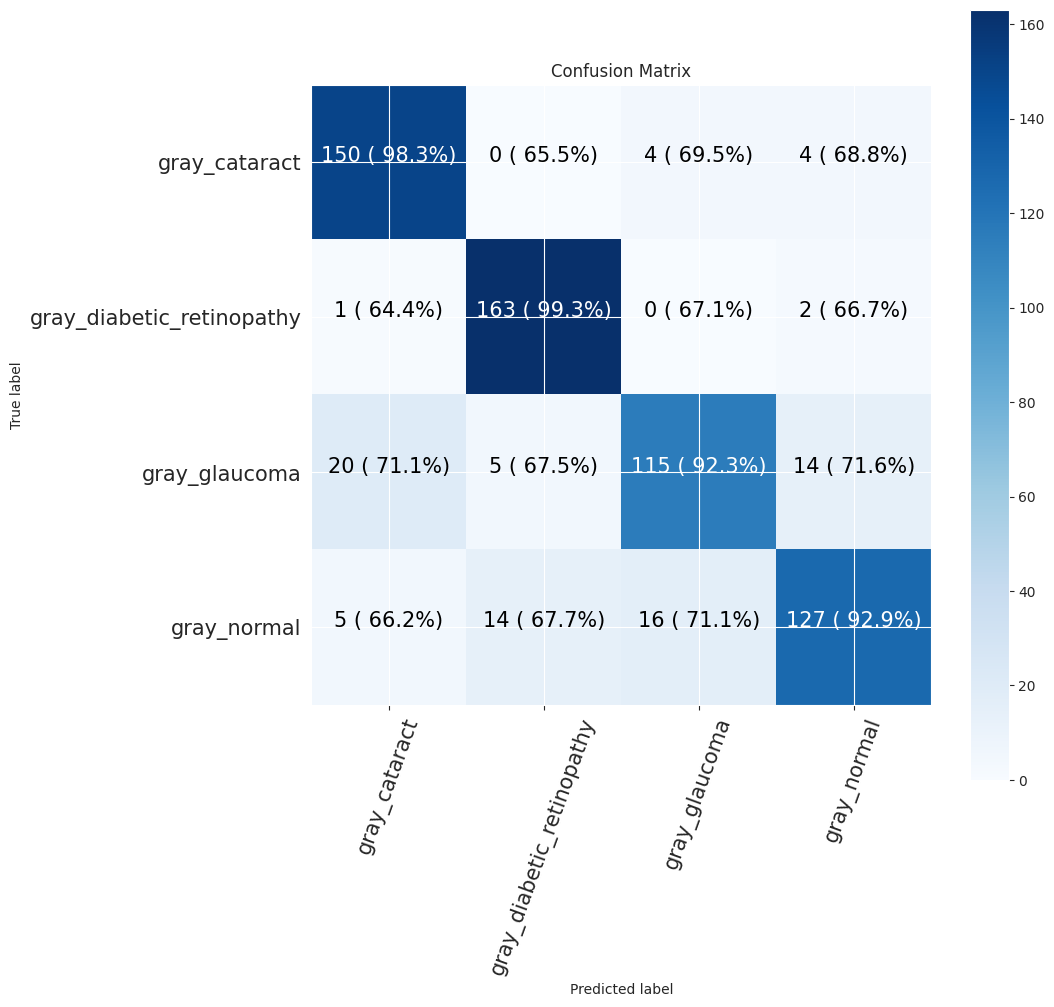

In [74]:
# Save Model
efficient_model.save("efficient_model.h5")

model = efficient_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


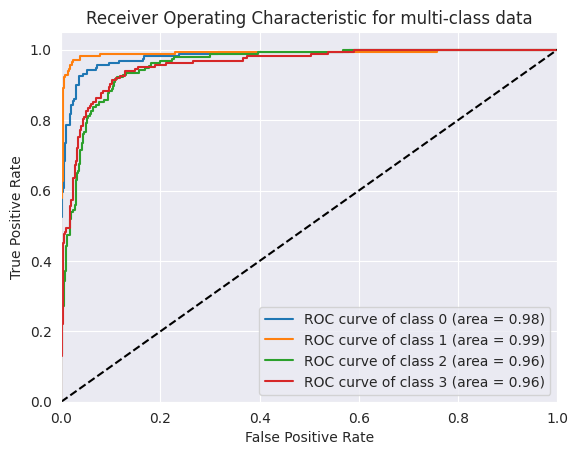

In [75]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **CNN model**

In [76]:
from tensorflow.keras.models import Sequential

# Create a Sequential model
cnn_model = Sequential()

# Add convolutional layers for feature extraction
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))  # Grayscale image has 1 channel

# Freeze the layers in the base model
for layer in cnn_model.layers:
    layer.trainable = False

grayscale_input = layers.Input(shape=(224, 224, 1))

grayscale_input = data_aug(grayscale_input)

cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output for dense layers
cnn_model.add(layers.Flatten())

# Add dense layers for classification
cnn_model.add(layers.Dense(512, activation='relu'))
cnn_model.add(layers.Dense(256, activation='relu'))
cnn_model.add(layers.Dense(4, activation='softmax'))  # Set num_classes to your specific number of classes

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
cnn_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 222, 222, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 26, 26, 128)      

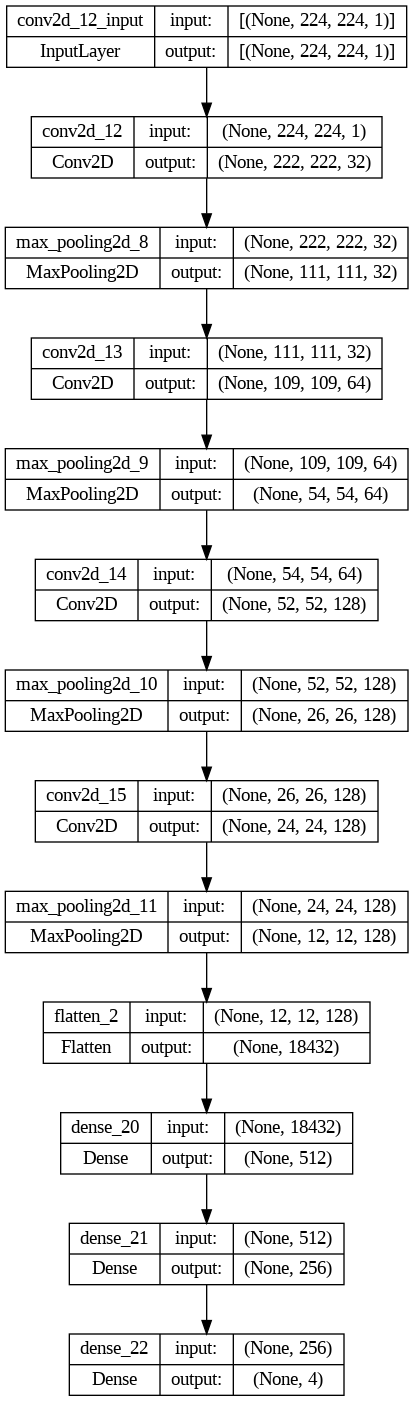

In [77]:
tf.keras.utils.plot_model(cnn_model, show_shapes=True)

In [78]:
cnn_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [79]:
cnn_history = cnn_model.fit(train_data,epochs = epoch, validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
47/47 [==============================] - 7s 80ms/step - loss: 6.4606 - accuracy: 0.4690 - val_loss: 1.0067 - val_accuracy: 0.6136 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 3s 67ms/step - loss: 1.0667 - accuracy: 0.6211 - val_loss: 0.8237 - val_accuracy: 0.6057 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 3s 67ms/step - loss: 0.7163 - accuracy: 0.6741 - val_loss: 0.7313 - val_accuracy: 0.6845 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 3s 67ms/step - loss: 0.6362 - accuracy: 0.7011 - val_loss: 0.6697 - val_accuracy: 0.6656 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 3s 67ms/step - loss: 0.6053 - accuracy: 0.7152 - val_loss: 0.7289 - val_accuracy: 0.6751 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 3s 67ms/step - loss: 0.5882 - accuracy: 0.7277 - val_loss: 0.6787 - val_accuracy: 0.6877 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 3s 66ms/step - loss: 0.5

CNN Evaluation

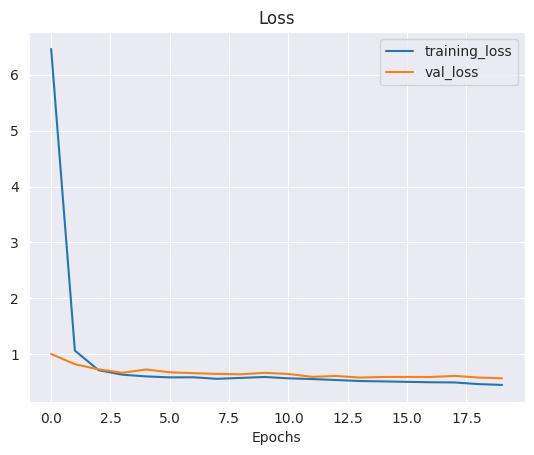

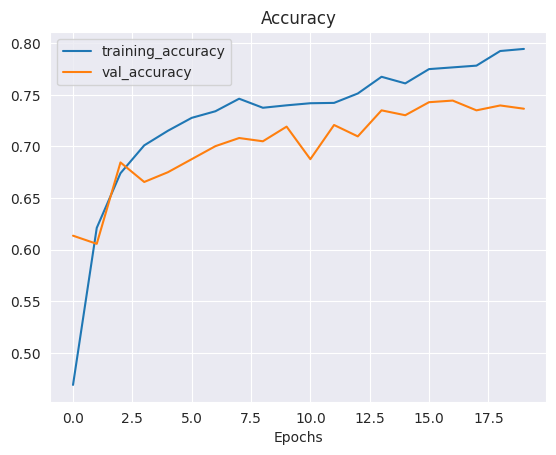

In [80]:
plot_loss_curves(cnn_history)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 24ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.42      0.49       158
           1       0.99      0.99      0.99       166
           2       0.54      0.55      0.55       154
           3       0.69      0.87      0.77       162

    accuracy                           0.72       640
   macro avg       0.70      0.71      0.70       640
weighted avg       0.71      0.72      0.71       640

Specificity: [0.1169284467713787, 0.3473684210526316, 0.15315315315315314, 0.28256513026052105]
Mean Squared Error: : 0.1373407393693924
The average AUC-ROC is 0.8977011040507267


[0.8273244781783681,
 0.6659619450317125,
 0.7908902691511387,
 0.7162471395881007,
 0.6850094876660342,
 0.9978858350951374,
 0.6563146997929606,
 0.6224256292906178,
 0.7855787476280834,
 0.6765327695560254,
 0.8571428571428571,
 0.7093821510297483,
 0.7020872865275142,
 0.6596194503171248,
 0.6956521739130435,
 0.9519450800915332]

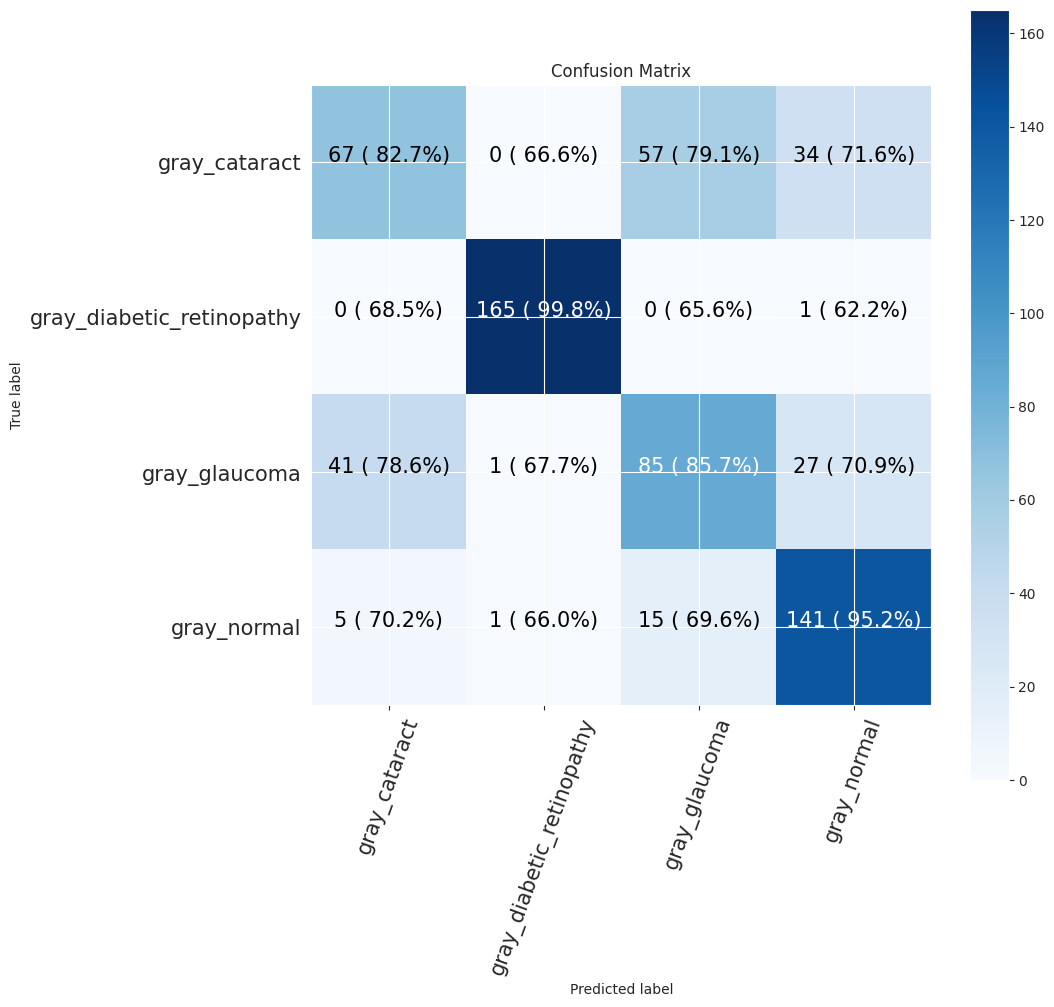

In [81]:
# Save Model
cnn_model.save("cnn_model.h5")

model = cnn_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


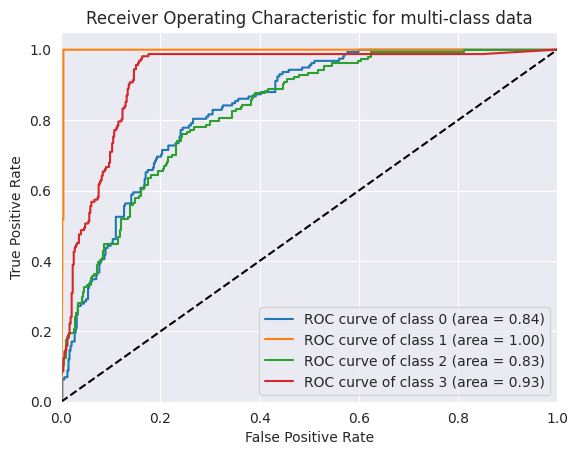

In [82]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet50 Model**



In [83]:
from tensorflow.keras.applications import ResNet50

# Load ResNet-50 without the top classification layers (include_top=False)
resnet50_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet50_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))

# grayscale_input = Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)
# Convert grayscale to 3 channels (matching the input requirement of ResNet-50)
conv_layer = Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-50 model
x = resnet50_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-50 model for grayscale images
resnet50_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet50_model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_7  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_23 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_24 (Dense)            (None, 4)                 4100      
                                                           

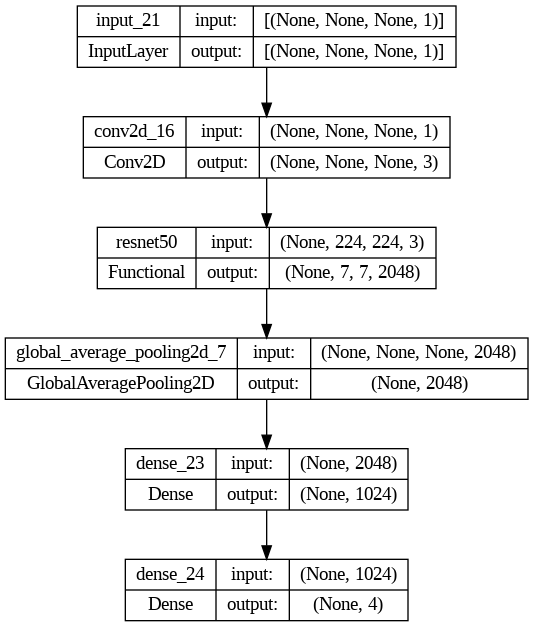

In [84]:
tf.keras.utils.plot_model(resnet50_model, show_shapes=True)

In [85]:
resnet50_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [86]:
resnet50_history = resnet50_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
47/47 [==============================] - 34s 578ms/step - loss: 1.0598 - accuracy: 0.6913 - val_loss: 0.5569 - val_accuracy: 0.7618 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 25s 520ms/step - loss: 0.3803 - accuracy: 0.8539 - val_loss: 0.4032 - val_accuracy: 0.8533 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 25s 519ms/step - loss: 0.3233 - accuracy: 0.8785 - val_loss: 0.3379 - val_accuracy: 0.8817 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 25s 522ms/step - loss: 0.2737 - accuracy: 0.8957 - val_loss: 0.2990 - val_accuracy: 0.8991 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 25s 521ms/step - loss: 0.2272 - accuracy: 0.9163 - val_loss: 0.3385 - val_accuracy: 0.8754 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 25s 519ms/step - loss: 0.2214 - accuracy: 0.9136 - val_loss: 0.3343 - val_accuracy: 0.8864 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 25s 519ms/st

ResNet50 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 2s 184ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       158
           1       0.99      0.96      0.98       166
           2       0.81      0.81      0.81       154
           3       0.84      0.84      0.84       162

    accuracy                           0.89       640
   macro avg       0.88      0.88      0.88       640
weighted avg       0.89      0.89      0.89       640

Specificity: [0.29554655870445345, 0.3333333333333333, 0.24271844660194175, 0.2698412698412698]
Mean Squared Error: : 0.1109117642045021
The average AUC-ROC is 0.9808906222870778


[0.9748427672955975,
 0.6694560669456067,
 0.6893004115226338,
 0.6805845511482255,
 0.6540880503144654,
 0.9874476987447699,
 0.6625514403292181,
 0.6597077244258872,
 0.7023060796645703,
 0.6778242677824268,
 0.9403292181069959,
 0.7139874739039666,
 0.6687631027253669,
 0.6652719665271967,
 0.7078189300411523,
 0.9457202505219207]

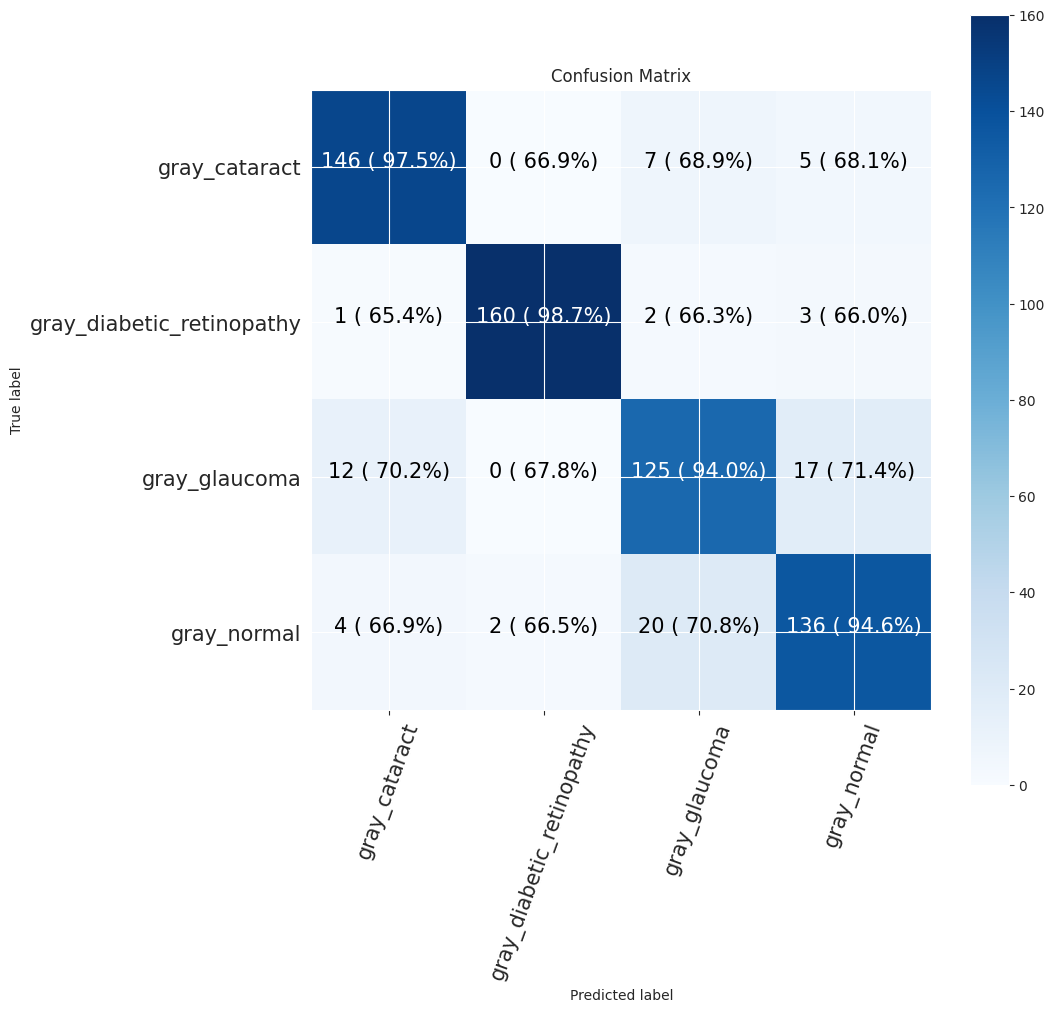

In [87]:
# Save Model
resnet50_model.save("resnet50_model.h5")

model = resnet50_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


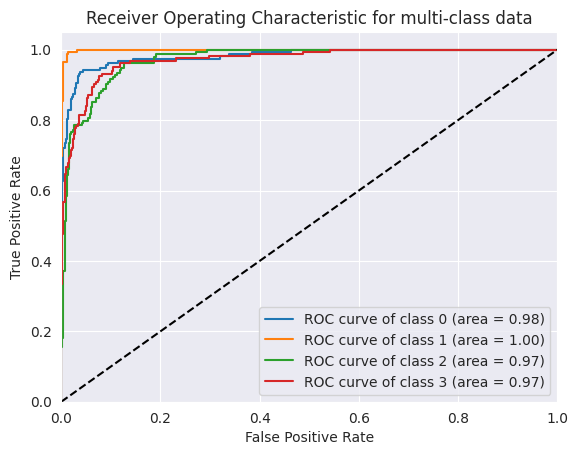

In [88]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()

# **ResNet101**

In [89]:
from tensorflow.keras.applications import ResNet101

# Load ResNet-101 without the top classification layers (include_top=False)
resnet101_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in resnet101_model.layers:
    layer.trainable = False

# Define the input layer for grayscale images (1 channel)
grayscale_input = layers.Input(shape=(224, 224, 1))
grayscale_input = data_aug(grayscale_input)

# Convert grayscale to 3 channels (matching the input requirement of ResNet-101)
conv_layer = layers.Conv2D(3, (3, 3), padding='same')(grayscale_input)

# Use the modified input as the input to the base ResNet-101 model
x = resnet101_model(conv_layer)

# Add custom classification layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
output = Dense(4, activation='softmax')(x)  # Set num_classes to your specific number of classes

# Create the modified ResNet-101 model for grayscale images
resnet101_model = Model(inputs=grayscale_input, outputs=output)

# Display model summary
resnet101_model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, None, None, 1)]   0         
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 3)     30        
                                                                 
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_average_pooling2d_8  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_25 (Dense)            (None, 1024)              2098176   
                                                                 
 dense_26 (Dense)            (None, 4)                 4100      
                                                           

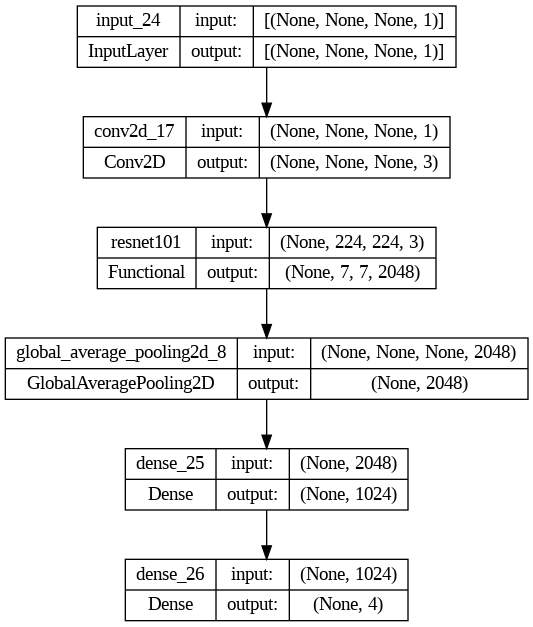

In [90]:
tf.keras.utils.plot_model(resnet101_model, show_shapes=True)

In [91]:
resnet101_model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),optimizer = tf.keras.optimizers.Adam(),metrics = ["accuracy"])

In [92]:
resnet101_history= resnet101_model.fit(train_data,epochs = epoch , validation_data = val_data,
                      callbacks = [early_stop,reduce_lr])

Epoch 1/20
47/47 [==============================] - 49s 893ms/step - loss: 0.8234 - accuracy: 0.7082 - val_loss: 0.4573 - val_accuracy: 0.8044 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 40s 852ms/step - loss: 0.4122 - accuracy: 0.8414 - val_loss: 0.3692 - val_accuracy: 0.8517 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 40s 840ms/step - loss: 0.3319 - accuracy: 0.8711 - val_loss: 0.3271 - val_accuracy: 0.8738 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 40s 851ms/step - loss: 0.3142 - accuracy: 0.8782 - val_loss: 0.3200 - val_accuracy: 0.8833 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 40s 849ms/step - loss: 0.2695 - accuracy: 0.9018 - val_loss: 0.3277 - val_accuracy: 0.8612 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 40s 843ms/step - loss: 0.2911 - accuracy: 0.8846 - val_loss: 0.2959 - val_accuracy: 0.8912 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 40s 853ms/st

ResNet101 Evaluation

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 3s 310ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.92      0.88       158
           1       0.99      1.00      0.99       166
           2       0.84      0.76      0.80       154
           3       0.84      0.82      0.83       162

    accuracy                           0.88       640
   macro avg       0.87      0.87      0.87       640
weighted avg       0.88      0.88      0.88       640

Specificity: [0.29292929292929293, 0.350210970464135, 0.2237093690248566, 0.26232741617357]
Mean Squared Error: : 0.11180911213159561
The average AUC-ROC is 0.9802946127645225


[0.9721627408993576,
 0.6652542372881356,
 0.694,
 0.6881496881496881,
 0.6445396145610278,
 1.0,
 0.668,
 0.6548856548856549,
 0.7109207708779444,
 0.673728813559322,
 0.926,
 0.7172557172557172,
 0.6723768736616702,
 0.6610169491525424,
 0.712,
 0.9397089397089398]

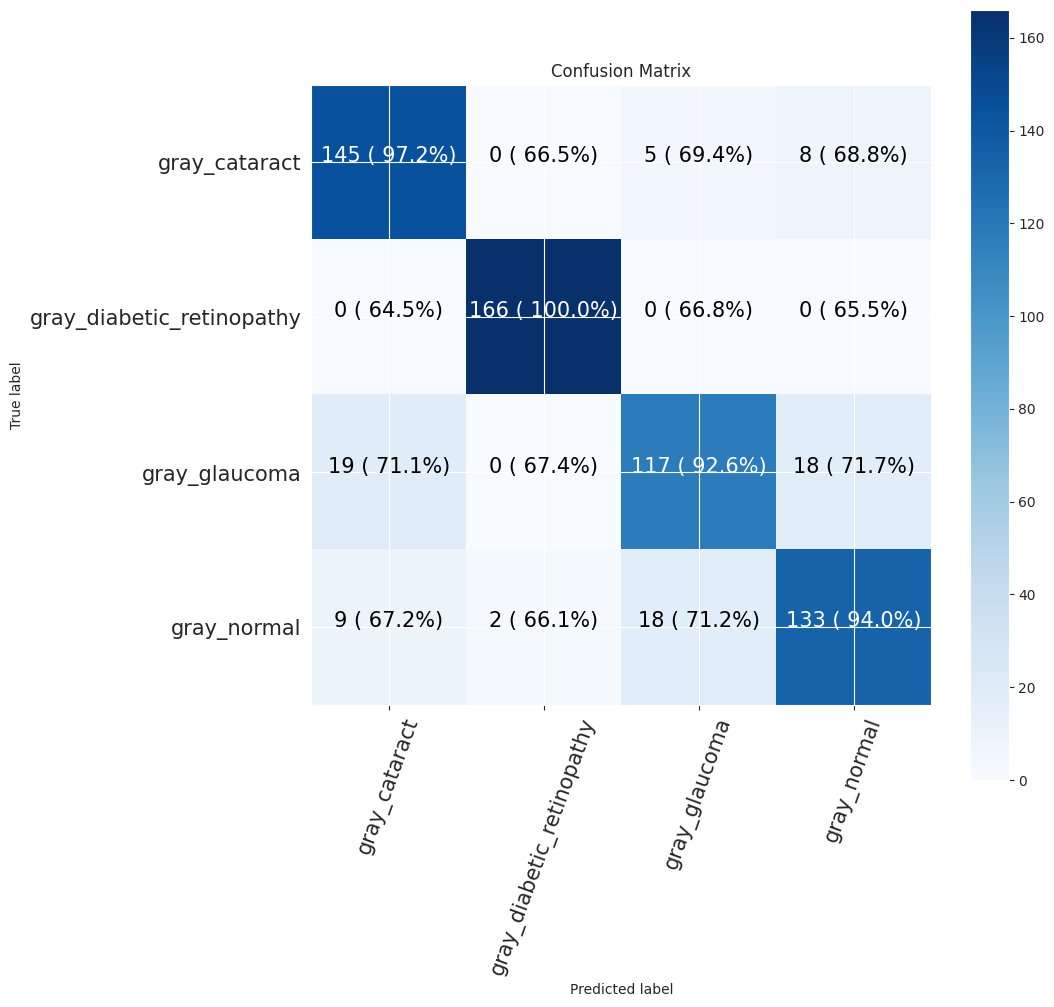

In [93]:
# Save Model
resnet101_model.save("resnet101_model.h5")

model = resnet101_model
X_test_data = test_data

pred_probs = model.predict(test_data)
pred_probs[0]
class_names = train_data.class_names
pred_classes = pred_probs.argmax(axis =1)

y_labels = []
for image,label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())
# y_labels[:20]

# Predict using the model
y_pred = model.predict(test_data)

# Convert raw predictions to probabilities using TensorFlow's softmax function
y_probs = tf.nn.softmax(y_pred, axis=-1)  # Adjust axis if needed

n_classes = 4

# Predict labels
y_pred_labels = predict_labels(model, X_test_data)

# Display classification report
display_classification_report(y_labels, pred_classes)

# Calculate specificity
calculate_specificity(y_labels, pred_classes)

# Calculate MSE
calculate_mse(y_labels, y_probs, n_classes)

# Calculate ROC-AUC score
calculate_roc_auc_score(y_labels, y_probs)

# Confusion matrix
make_confusion_matrix(y_labels,pred_classes,classes = class_names,figsize = (10,10))



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


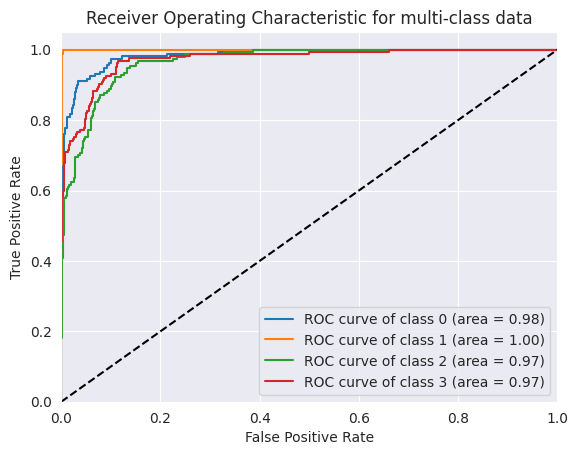

In [94]:
# Convert y_labels to a numpy array
y_labels_array = np.array(y_labels)

# Create a OneHotEncoder instance
encoder = OneHotEncoder(sparse=False)

# Fit the encoder to the y_labels_array and transform it to a binary matrix
y_bin = encoder.fit_transform(y_labels_array.reshape(-1, 1))

# Compute the ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class data')
plt.legend(loc="lower right")
plt.show()